In [3]:
import tensorflow_federated as tff
import collections
import os
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, InputLayer, Softmax
from tensorflow.keras.models import Sequential
import pickle
from joblib import dump,load 
from sklearn.model_selection import train_test_split,KFold
from sklearn.metrics import roc_curve, confusion_matrix,accuracy_score,auc, classification_report,ConfusionMatrixDisplay
from sklearn.decomposition import PCA,KernelPCA
from itertools import cycle
import seaborn as sns
import tensorflow_privacy as tfp
from sklearn.preprocessing import label_binarize


FIGURESIZE=(15,10)
FONTSIZE=18
plt.rcParams['figure.figsize'] = FIGURESIZE
plt.rcParams['font.size'] = FONTSIZE
plt.rcParams['xtick.labelsize'] = FONTSIZE
plt.rcParams['ytick.labelsize'] = FONTSIZE

2022-07-19 18:45:32.419817: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-19 18:45:32.419861: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


### Data Visualization

In [2]:
# with open('/home/harinadh_asr2/project/WESAD/S3_train_data.npy', 'rb') as f:
# data = np.load('/home/harinadh_asr2/project/WESAD/S2_train_data.npy',allow_pickle=True)
with open('/home/harinadh_asr2/project/WESAD/S2/S2.pkl', 'rb') as f:
    data = pickle.load(f, encoding='latin1')

In [21]:
data['signal']['wrist'].keys()

dict_keys(['ACC', 'BVP', 'EDA', 'TEMP'])

In [4]:
# plt.hist(data.item().get('features')[:,1])

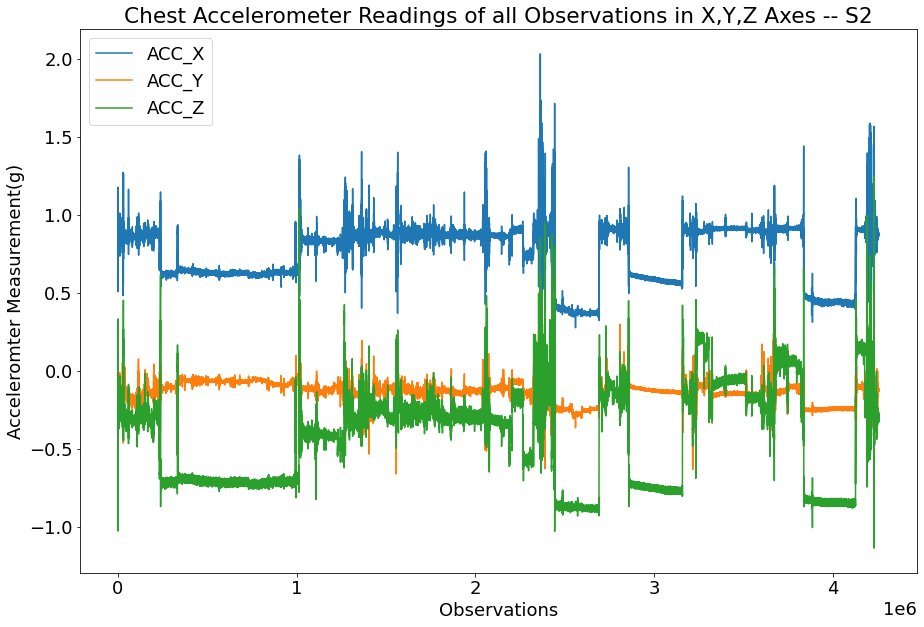

In [5]:
acc = data.get('signal',{}).get('chest',{}).get('ACC',np.array([]))

plt.plot(data['signal']['chest']['ACC'])
plt.ylabel('Acceleromter Measurement(g)')
plt.xlabel('Observations')
plt.title('Chest Accelerometer Readings of all Observations in X,Y,Z Axes -- S2')
plt.legend(['ACC_X','ACC_Y','ACC_Z'])
plt.savefig('chest_acc.png')

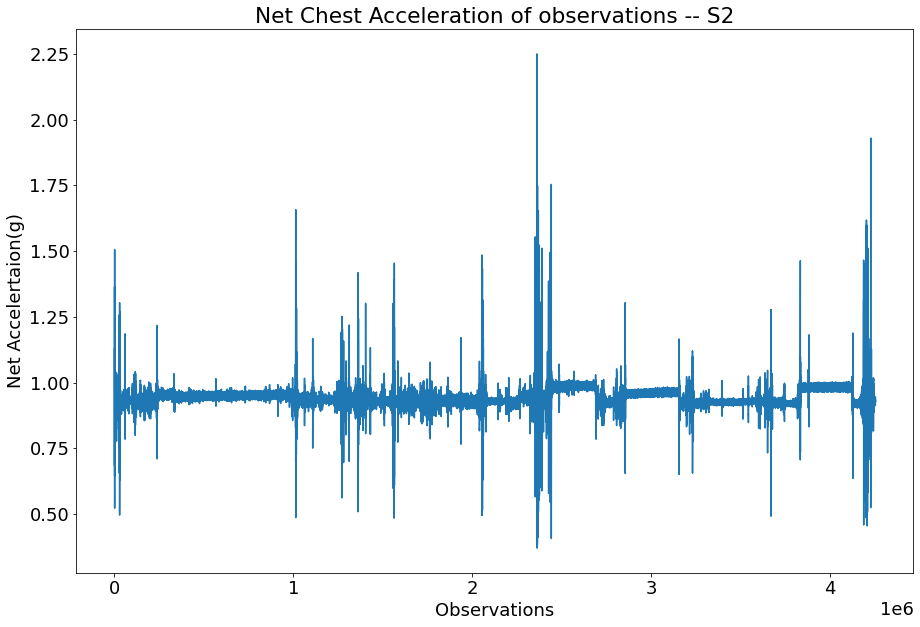

In [6]:
plt.plot(np.sqrt(acc[:,0]**2+acc[:,1]**2+acc[:,2]**2))
plt.ylabel('Net Accelertaion(g)')
plt.xlabel('Observations') 
plt.title('Net Chest Acceleration of observations -- S2')
plt.savefig('chest_net_acc.png')

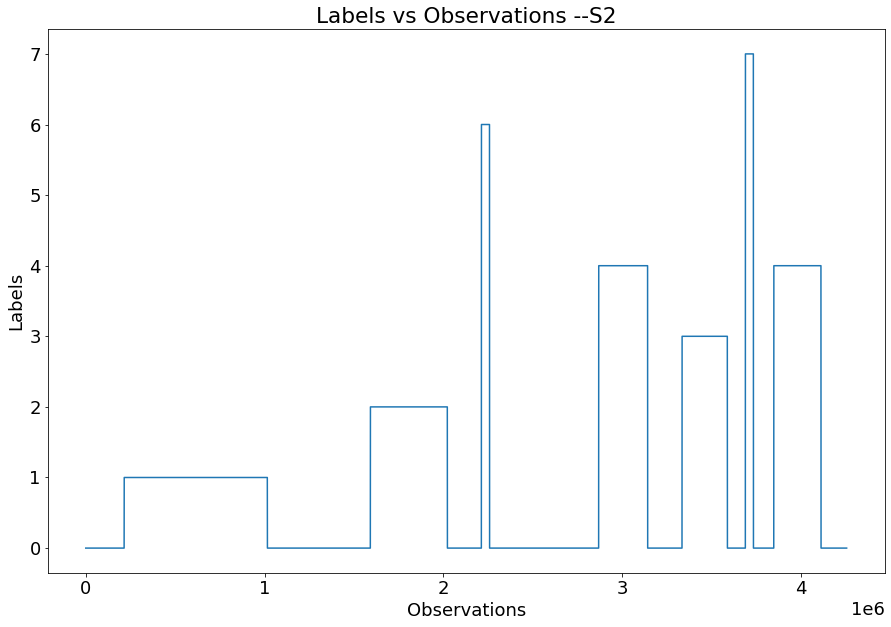

In [7]:
plt.plot(data['label'])
plt.ylabel('Labels')
plt.xlabel('Observations') 
plt.title('Labels vs Observations --S2')
plt.savefig('labels.png')

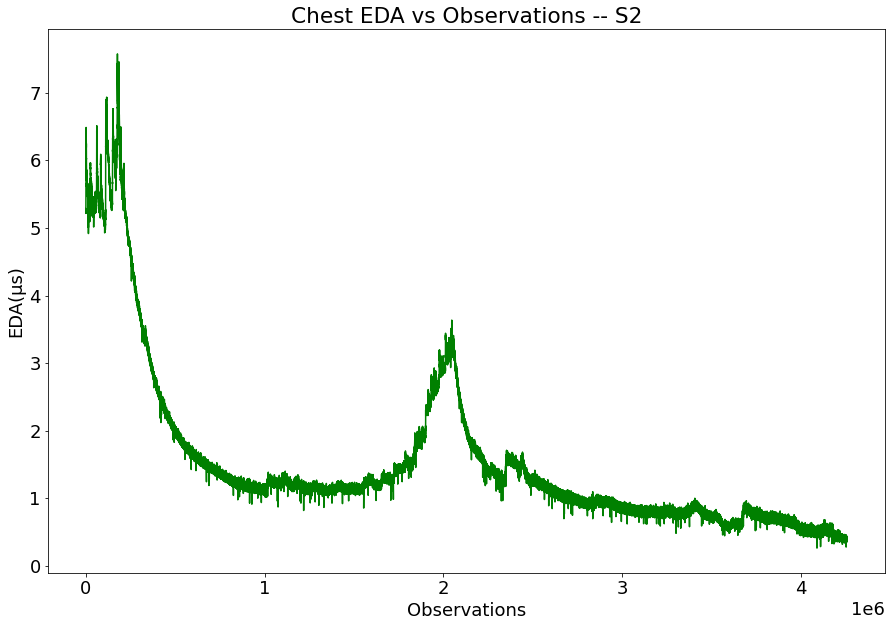

In [8]:
plt.plot(data['signal']['chest']['EDA'],"g")

plt.ylabel('EDA(μs)')
plt.xlabel('Observations') 
plt.title('Chest EDA vs Observations -- S2')
plt.savefig('chest_eda.png')

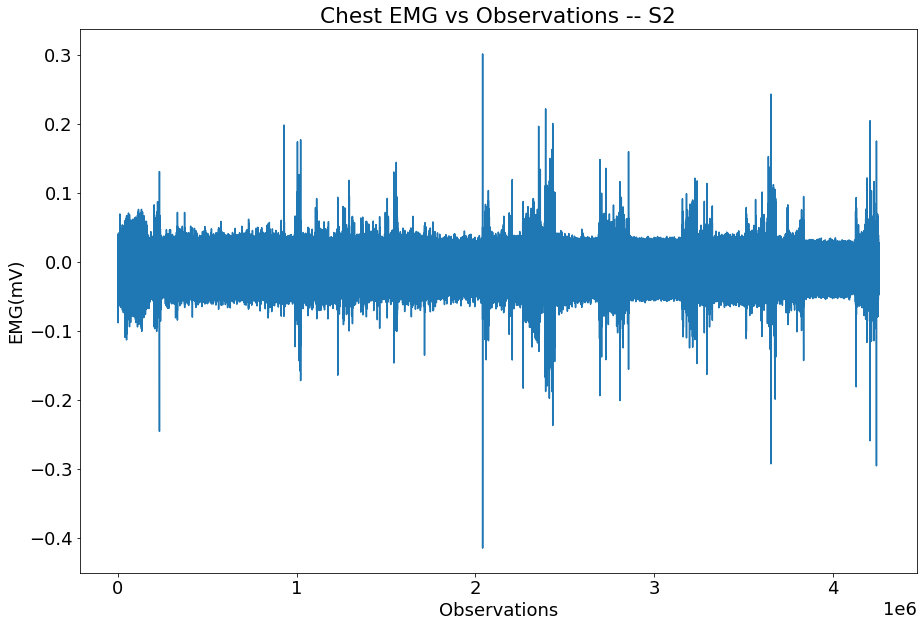

In [9]:
plt.plot(data['signal']['chest']['EMG'])

plt.ylabel('EMG(mV)')
plt.xlabel('Observations') 
plt.title('Chest EMG vs Observations -- S2')
plt.savefig('chest_EMG.png')

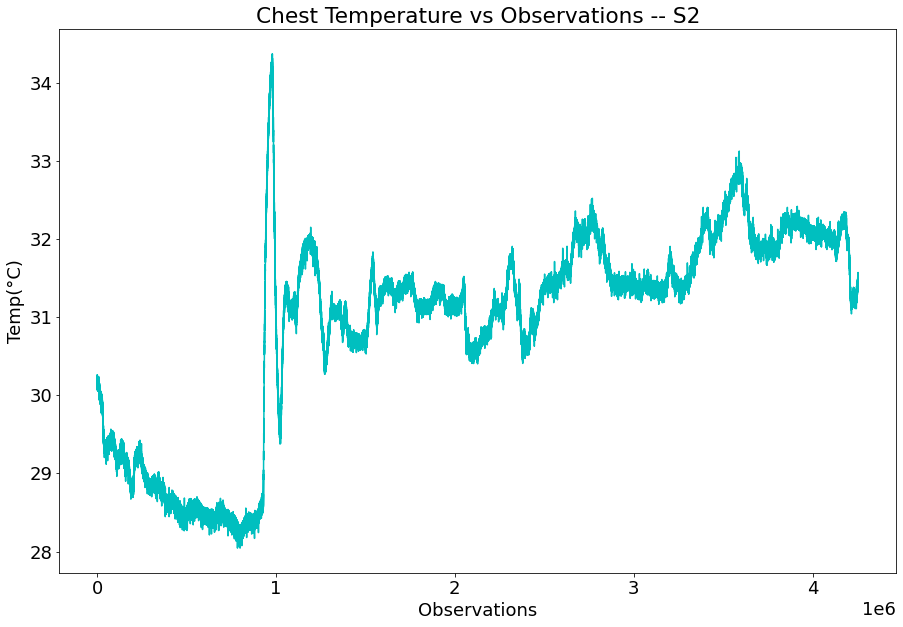

In [10]:
plt.plot(data['signal']['chest']['Temp'],"c")

plt.ylabel('Temp(°C)')
plt.xlabel('Observations') 
plt.title('Chest Temperature vs Observations -- S2')
plt.savefig('chest_Temp.png')

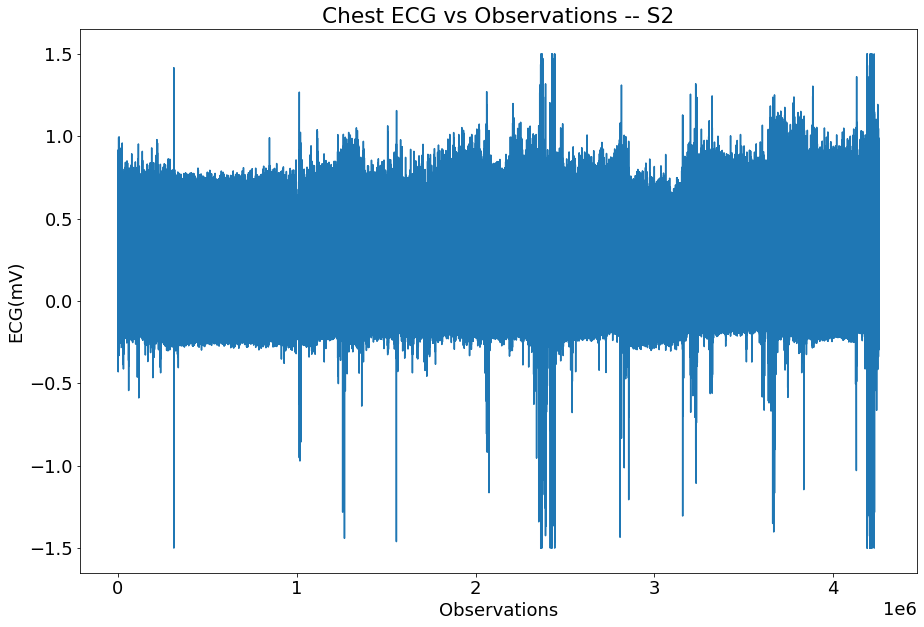

In [11]:
plt.plot(data['signal']['chest']['ECG'])
plt.ylabel('ECG(mV)')
plt.xlabel('Observations') 
plt.title('Chest ECG vs Observations -- S2')
plt.savefig('chest_ECG.png')

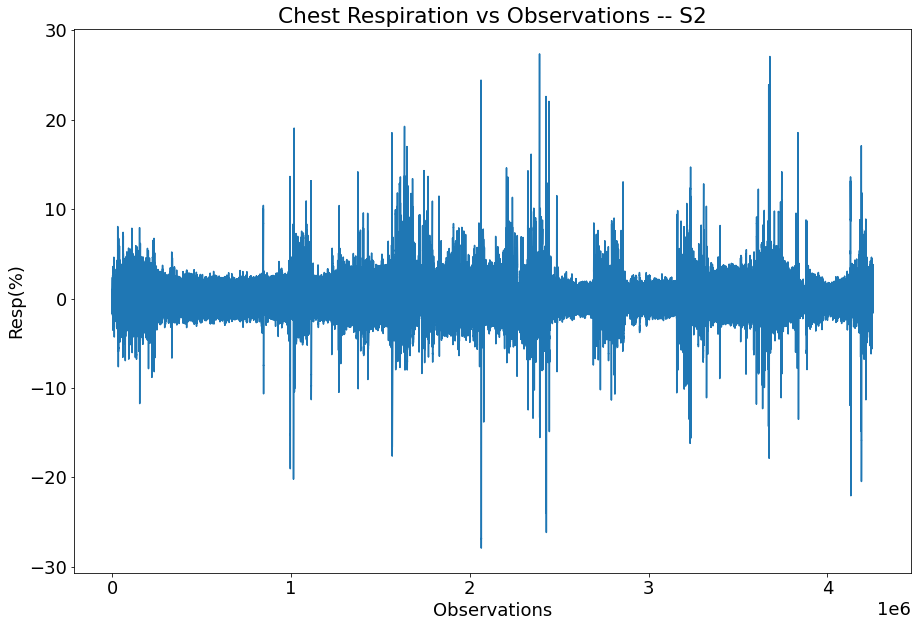

In [12]:
plt.plot(data['signal']['chest']['Resp'])
plt.ylabel('Resp(%)')
plt.xlabel('Observations') 
plt.title('Chest Respiration vs Observations -- S2')
plt.savefig('chest_Resp.png')

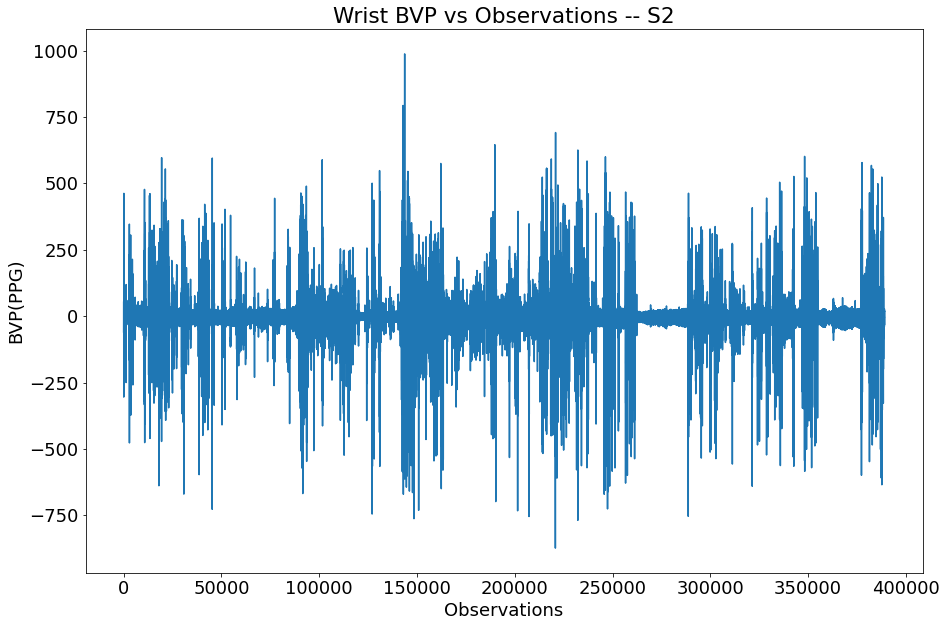

In [13]:
plt.plot(data['signal']['wrist']['BVP'])
plt.ylabel('BVP(PPG)')
plt.xlabel('Observations') 
plt.title('Wrist BVP vs Observations -- S2')
plt.savefig('wrist_BVP.png')

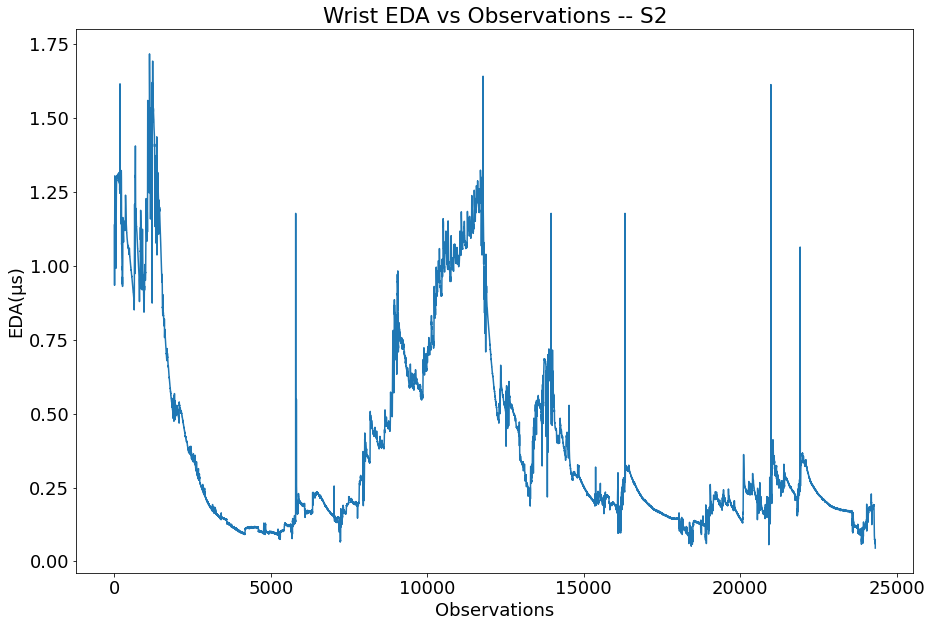

In [14]:
plt.plot(data['signal']['wrist']['EDA'])
plt.ylabel('EDA(μs)')
plt.xlabel('Observations') 
plt.title('Wrist EDA vs Observations -- S2')
plt.savefig('wrist_EDA.png')

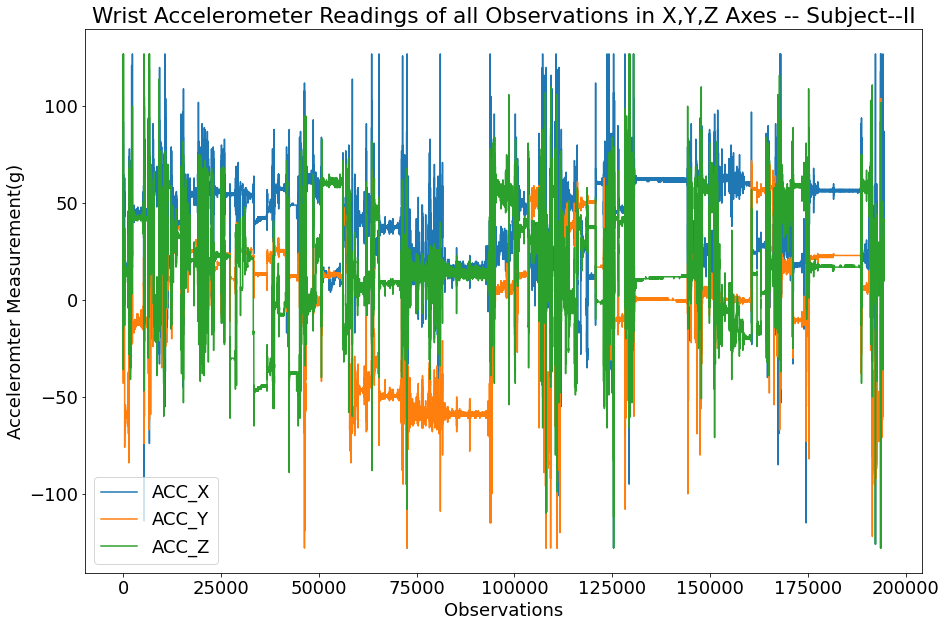

In [15]:
acc = data.get('signal',{}).get('wrist',{}).get('ACC',np.array([]))

plt.plot(data['signal']['wrist']['ACC'])
plt.ylabel('Acceleromter Measurement(g)')
plt.xlabel('Observations')
plt.title('Wrist Accelerometer Readings of all Observations in X,Y,Z Axes -- Subject--II')
plt.legend(['ACC_X','ACC_Y','ACC_Z'])
plt.savefig('wrist_ACC.png')

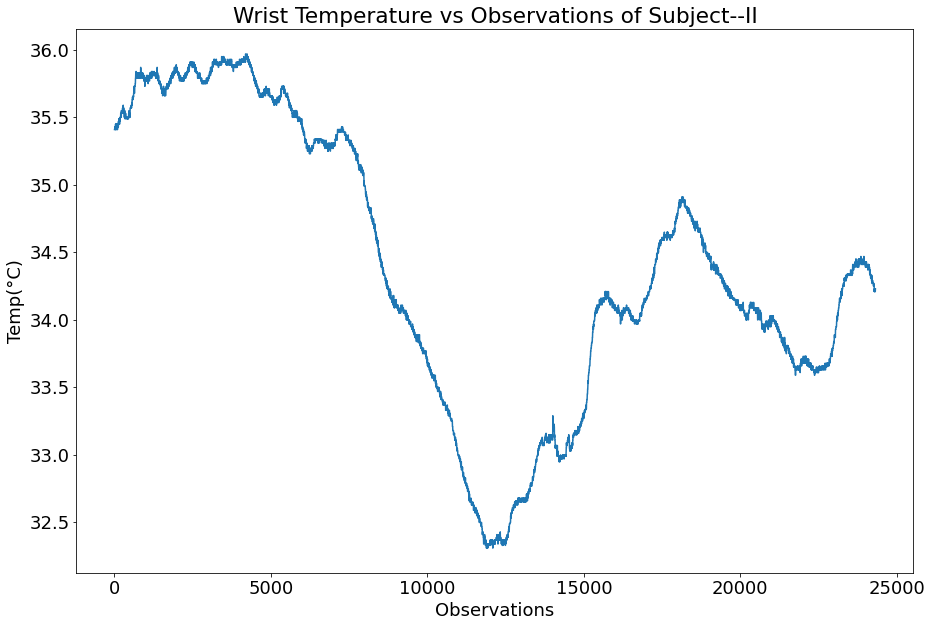

In [16]:
plt.plot(data['signal']['wrist']['TEMP'])
plt.ylabel('Temp(°C)')
plt.xlabel('Observations') 
plt.title('Wrist Temperature vs Observations of Subject--II')
plt.savefig('wrist_Temp.png')

### Principal Component Analysis

In [ ]:
pca = PCA(n_components=8)
pca.fit(features)

In [ ]:
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Components')
plt.ylabel('Variance Explained')
plt.show()

In [ ]:
features = pca.transform(features)

###  Centralized Training on All Data

In [96]:
model = tf.keras.models.Sequential([
      tf.keras.layers.InputLayer(input_shape=(56,)),
      tf.keras.layers.Dense(20,activation='relu'),
      tf.keras.layers.Dense(10,activation='relu'),
      tf.keras.layers.Dense(3, use_bias=True, name="output", activation='softmax')
  ])

opt =  tf.keras.optimizers.Adam(learning_rate=0.00001, beta_1=0.9, beta_2=0.999, epsilon= None, decay=0.0, amsgrad= False)
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics='sparse_categorical_accuracy')

In [97]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 20)                1140      
                                                                 
 dense_13 (Dense)            (None, 10)                210       
                                                                 
 output (Dense)              (None, 3)                 33        
                                                                 
Total params: 1,383
Trainable params: 1,383
Non-trainable params: 0
_________________________________________________________________


In [98]:
DATASET_PATH = "../WESAD/"
# federated_data = collections.OrderedDict()
train_dataset_dict = collections.OrderedDict()
test_dataset_dict = collections.OrderedDict()
X_train, X_test, y_train, y_test = [],[],[],[]

for root, dirnames, filenames in os.walk(DATASET_PATH, topdown=True):
    for file_name in filenames :
        
        if file_name.endswith('.npy'):
            subject_no = file_name.split('_')[0]
            file_path = os.path.join(root,file_name)

            if os.path.exists(file_path):           
                data = np.load(file_path, allow_pickle=True)
                
                if file_name.endswith('train_data.npy'):
                    X_train +=[data.item().get('features')]
                    y_train +=[data.item().get('labels')]
                    print(f'Number of examples in subject {subject_no} for train: ',data.item().get('features').shape[0])
#                     train_dataset_dict[subject_no] = collections.OrderedDict((('features', data.item().get('features')),('labels',data.item().get('labels'))))
                elif file_name.endswith('test_data.npy'):
                    X_test += [data.item().get('features')]
                    y_test += [data.item().get('labels')]
                    print(f'Number of examples in subject {subject_no}: for test ',data.item().get('features').shape[0])
#                     test_dataset_dict[subject_no] = collections.OrderedDict((('features', data.item().get('features')),('labels',data.item().get('labels'))))

Number of examples in subject S14: for test  671
Number of examples in subject S17: for test  686
Number of examples in subject S15: for test  673
Number of examples in subject S3: for test  649
Number of examples in subject S16 for train:  1561
Number of examples in subject S10 for train:  1598
Number of examples in subject S6: for test  664
Number of examples in subject S2: for test  639
Number of examples in subject S2 for train:  1491
Number of examples in subject S9 for train:  1543
Number of examples in subject S4: for test  653
Number of examples in subject S8 for train:  1554
Number of examples in subject S6 for train:  1548
Number of examples in subject S9: for test  662
Number of examples in subject S4 for train:  1521
Number of examples in subject S7 for train:  1545
Number of examples in subject S7: for test  663
Number of examples in subject S13: for test  669
Number of examples in subject S13 for train:  1559
Number of examples in subject S11: for test  672
Number of exam

In [99]:
X_train,y_train = np.vstack(X_train), np.concatenate(y_train)
X_test,y_test = np.vstack(X_test), np.concatenate(y_test)
y_train = y_train-1
y_test = y_test-1

In [100]:
# Order is ACC, ECG, EMG, EDA, Temp, Resp
# fields order is Max,Min,Std,Mean

# pd.set_option('display.float_format', lambda x: '%.3f' % x)
# pd.DataFrame(X_train).describe().transpose()

In [101]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.3, random_state=42, stratify=y_train)

In [ ]:
# data = np.load('/home/harinadh_asr2/project/WESAD/S11_train_data.npy', allow_pickle=True)
# X_train, X_valid, y_train,y_valid = train_test_split(data.item()['features'], data.item()['labels'],test_size=0.3, random_state=42)                                     

In [ ]:
# y_train = y_train-1
# y_valid = y_valid-1

In [102]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0.001,
    patience=5,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)

In [103]:
history = model.fit(
    x=X_train,
    y=y_train,
    batch_size=8,
    epochs=50,
    verbose="auto",
    callbacks=[early_stopping],
    validation_split=0.0,
    validation_data=(X_valid,y_valid),
    shuffle=True,
    class_weight=None,
    sample_weight=None,
    initial_epoch=0,
    steps_per_epoch=None,
    validation_steps=None,
    validation_batch_size=None,
    validation_freq=1,
    max_queue_size=10,
    workers=1,
    use_multiprocessing=False,
)

Epoch 1/50
2038/2038 [==============================] - 4s 2ms/step - loss: 1.1996 - sparse_categorical_accuracy: 0.3390 - val_loss: 1.0830 - val_sparse_categorical_accuracy: 0.4342
Epoch 2/50
2038/2038 [==============================] - 4s 2ms/step - loss: 0.9815 - sparse_categorical_accuracy: 0.5431 - val_loss: 0.9012 - val_sparse_categorical_accuracy: 0.6295
Epoch 3/50
2038/2038 [==============================] - 4s 2ms/step - loss: 0.8258 - sparse_categorical_accuracy: 0.6867 - val_loss: 0.7634 - val_sparse_categorical_accuracy: 0.7305
Epoch 4/50
2038/2038 [==============================] - 4s 2ms/step - loss: 0.7063 - sparse_categorical_accuracy: 0.7537 - val_loss: 0.6583 - val_sparse_categorical_accuracy: 0.7734
Epoch 5/50
2038/2038 [==============================] - 4s 2ms/step - loss: 0.6159 - sparse_categorical_accuracy: 0.7868 - val_loss: 0.5805 - val_sparse_categorical_accuracy: 0.7955
Epoch 6/50
2038/2038 [==============================] - 4s 2ms/step - loss: 0.5480 - spars

Epoch 46/50
2038/2038 [==============================] - 4s 2ms/step - loss: 0.1573 - sparse_categorical_accuracy: 0.9491 - val_loss: 0.1680 - val_sparse_categorical_accuracy: 0.9506
Epoch 47/50
2038/2038 [==============================] - 4s 2ms/step - loss: 0.1548 - sparse_categorical_accuracy: 0.9507 - val_loss: 0.1657 - val_sparse_categorical_accuracy: 0.9521
Epoch 48/50
2038/2038 [==============================] - 4s 2ms/step - loss: 0.1525 - sparse_categorical_accuracy: 0.9513 - val_loss: 0.1635 - val_sparse_categorical_accuracy: 0.9528
Epoch 49/50
2038/2038 [==============================] - 4s 2ms/step - loss: 0.1502 - sparse_categorical_accuracy: 0.9521 - val_loss: 0.1613 - val_sparse_categorical_accuracy: 0.9535
Epoch 50/50
2038/2038 [==============================] - 4s 2ms/step - loss: 0.1480 - sparse_categorical_accuracy: 0.9534 - val_loss: 0.1592 - val_sparse_categorical_accuracy: 0.9541


### Model Evaluation

In [ ]:
model.evaluate(X_train, y_train, verbose=0)

In [ ]:
model.evaluate(X_test, y_test, verbose=0)

In [ ]:
y_preds = np.argmax(model.predict(X_test),axis=-1)

In [ ]:
 # Binarize the output
y_test = label_binarize(y_test, classes=[0, 1, 2])
n_classes = y_test.shape[1]
y_preds = label_binarize(y_preds, classes=[0, 1, 2])

### ROC Curve

In [ ]:
fpr = dict()
tpr = dict()
roc_auc = dict()
lw=2
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_preds[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.savefig('ROC_AUC model.png')

### Validation Accuracy Curve

In [ ]:
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.ylabel('Validation Set Accuracy')
plt.xlabel('Epochs')
plt.title('Validation Set Accuracy vs Epochs')
plt.savefig('Validation Accuracy.png')

### Validation Loss Curve

In [ ]:
plt.plot(history.history['loss'])
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.title('Loss vs Epochs')
plt.savefig('Validaiton Loss_curve.png')

In [ ]:
y_test = np.argmax(y_test,axis=-1)
y_preds = np.argmax(y_preds,axis=-1)

### Classification Report


In [ ]:
target_names = ['Neutral', 'Stress', 'Amusement']
pd.DataFrame(classification_report(y_test, y_preds, target_names=target_names,output_dict=True)).transpose()

In [ ]:
cm = confusion_matrix(y_test, y_preds)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
# sns.heatmap(cmn,annot=True, cmap='magma_r')
cmd = ConfusionMatrixDisplay(cmn, display_labels=['Neutral','Stress','Amusement'])
cmd.plot(cmap='magma_r')

# plt.xlabel('Predicted Class')
# plt.ylabel('True Class')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png',bbox_inches='tight', dpi=150)

In [ ]:
cmd = metrics.ConfusionMatrixDisplay(cm, display_labels=['Neutral','Stress','Amusement'])
cmd.plot(cmap='magma_r')

* Performed Stratified split to sample train and test in same proportion so that labels ratio is same in test and train data
* Performed same step for train and validation split
* Used held out validation for model training

## Federated Training

In [101]:
DATASET_PATH = "../WESAD/"
# federated_data = collections.OrderedDict()
train_dataset_dict = collections.OrderedDict()
test_dataset_dict = collections.OrderedDict()
validation_dataset_dict = collections.OrderedDict()
sum_ = 0
for root, dirnames, filenames in os.walk(DATASET_PATH, topdown=True):
    for file_name in filenames :
        
        if file_name.endswith('.npy'):
            subject_no = file_name.split('_')[0]
            file_path = os.path.join(root,file_name)

            if os.path.exists(file_path):           
                data = np.load(file_path, allow_pickle=True)
                
                if file_name.endswith('train_data.npy'):
                    
                    X_train, X_valid, y_train,y_valid = train_test_split(data.item()['features'], data.item()['labels'],test_size=0.25, random_state=42)
                    y_train,y_valid = y_train-1, y_valid-1
                    train_dataset_dict[subject_no] = collections.OrderedDict((('features', X_train),('labels',y_train)))
                    validation_dataset_dict[subject_no] = collections.OrderedDict((('features', X_valid),('labels',y_valid)))
                    print(f'Number of examples in subject {subject_no} for train: ',X_train.shape[0])
#                     sum_+=X_train.shape[0]
                                                                                                 
                elif file_name.endswith('test_data.npy'):
                    print(f'Number of examples in subject {subject_no}: for test ',data.item().get('features').shape[0])
                    test_dataset_dict[subject_no] = collections.OrderedDict((('features', data.item().get('features')),('labels',data.item().get('labels')-1)))

Number of examples in subject S14: for test  671
Number of examples in subject S17: for test  686
Number of examples in subject S15: for test  673
Number of examples in subject S3: for test  649
Number of examples in subject S16 for train:  1170
Number of examples in subject S10 for train:  1198
Number of examples in subject S6: for test  664
Number of examples in subject S2: for test  639
Number of examples in subject S2 for train:  1118
Number of examples in subject S9 for train:  1157
Number of examples in subject S4: for test  653
Number of examples in subject S8 for train:  1165
Number of examples in subject S6 for train:  1161
Number of examples in subject S9: for test  662
Number of examples in subject S4 for train:  1140
Number of examples in subject S7 for train:  1158
Number of examples in subject S7: for test  663
Number of examples in subject S13: for test  669
Number of examples in subject S13 for train:  1169
Number of examples in subject S11: for test  672
Number of exam

In [102]:
# 1/sum_

In [103]:
tff_dataset_train = tff.simulation.datasets.TestClientData(train_dataset_dict)
tff_dataset_test = tff.simulation.datasets.TestClientData(test_dataset_dict)
tff_dataset_valid = tff.simulation.datasets.TestClientData(validation_dataset_dict)

2022-07-19 19:20:00.844747: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-07-19 19:20:00.844799: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-19 19:20:00.844824: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (instance-1): /proc/driver/nvidia/version does not exist
2022-07-19 19:20:00.845114: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Plotting Label Distribution of Training Data

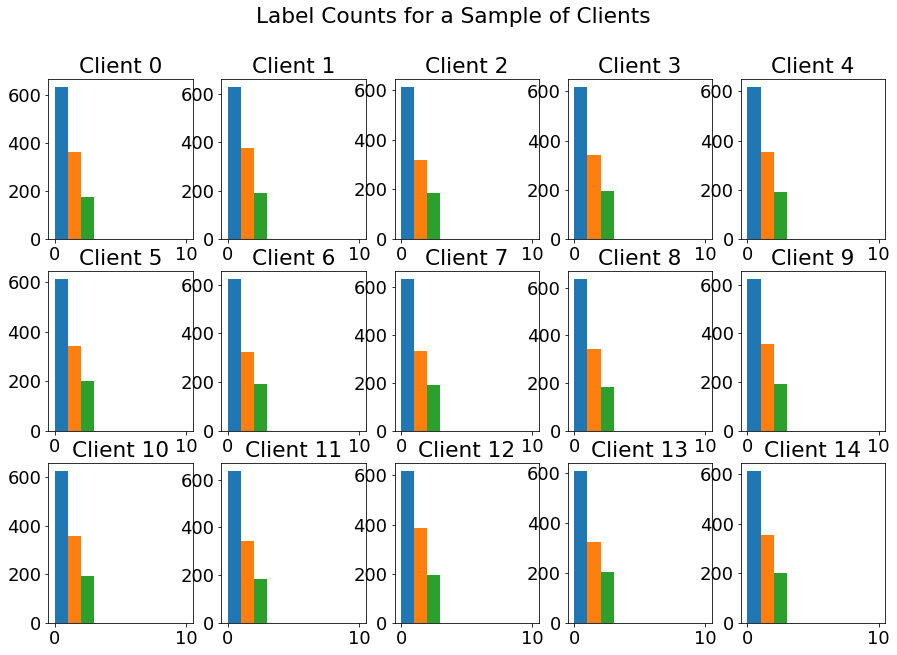

In [24]:
# Number of examples per layer for a sample of clients
f = plt.figure(figsize=(15, 10))
f.suptitle('Label Counts for a Sample of Clients')
for i in range(15):
    client_dataset = tff_dataset_train.create_tf_dataset_for_client(tff_dataset_train.client_ids[i])
    plot_data = collections.defaultdict(list)
    for example in client_dataset:
        # Append counts individually per label to make plots
        # more colorful instead of one color per plot.
        label = example['labels'].numpy()
        plot_data[label].append(label)
    plt.subplot(3, 5, i+1)
    plt.title('Client {}'.format(i)) 
    for j in range(0,4):
        plt.hist(
        plot_data[j],
        density=False,
        bins=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
plt.savefig('label_distribution.png')

In [57]:
client_dataset = tff_dataset_train.create_tf_dataset_for_client(tff_dataset_train.client_ids[0])

In [58]:
tff_dataset_train.client_ids[0]

'S16'

* The data from different client is same and not showing Non-IID characteristics.
* For now, lets go with creating a federated model and come back later to simulate real time federate characteristics.

#### Plotting Label Distribution of Validation Data

#### Create a example dataset for one client

In [104]:
example_dataset = tff_dataset_train.create_tf_dataset_for_client(tff_dataset_train.client_ids[0])

### Preprocess Function to perform batching and standardization

In [105]:
NUM_CLIENTS = 15
NUM_EPOCHS = 3
BATCH_SIZE = 16
SHUFFLE_BUFFER = 200
PREFETCH_BUFFER = 10
train_transformation = {}

def preprocess_fn(dataset, train):
    
    def batch_format_fn(element,epsilon=1e-8, train=True):
        """Flatten a batch `features` and return the features as an `OrderedDict`."""
        
        return collections.OrderedDict(
            x=tf.reshape(element['features'], [-1, 56]),
            y=tf.reshape(element['labels'], [-1, 1]))

    return dataset.repeat(NUM_EPOCHS).shuffle(SHUFFLE_BUFFER, seed=1).batch(
          BATCH_SIZE).map(lambda x : batch_format_fn(x,train)).prefetch(PREFETCH_BUFFER)

#### Create an example spec

In [106]:
data = preprocess_fn(example_dataset, train=True)

#### Creating Model to be used on Client Devices

In [107]:
def create_keras_model():
    
    model = tf.keras.models.Sequential([
          tf.keras.layers.InputLayer(input_shape=(56,)),
          tf.keras.layers.Dense(20,activation='relu'),
          tf.keras.layers.Dense(10,activation='relu'),
          tf.keras.layers.Dense(3, use_bias=True, name="output", activation='softmax')
      ])
    
    return model

### Create a Model Function to wrap client model for TFF context

In [108]:
def model_fn():
  # We _must_ create a new model here, and _not_ capture it from an external
  # scope. TFF will call this within different graph contexts.
    keras_model = create_keras_model()
    return tff.learning.from_keras_model(
      keras_model,
      input_spec=data.element_spec,
      loss=tf.keras.losses.SparseCategoricalCrossentropy(),
      metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])


### Create TFF Federated Averaging Process for Training

In [109]:
federated_training = tff.learning.algorithms.build_unweighted_fed_avg(
    model_fn,
    client_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=0.0001,momentum=0.9),
    server_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=1)
)

### Create TFF Federated Validation(Evaluation)

In [110]:
federated_validation = tff.learning.build_federated_evaluation(model_fn)

## Initialize Federated Training Process

In [111]:
state = federated_training.initialize()

training_metrics = collections.defaultdict(list)
validation_metrics = collections.defaultdict(list)

NUM_ROUNDS = 100
for round_num in range(0,NUM_ROUNDS):
    
    participating_clients = np.random.choice(tff_dataset_train.client_ids,size=10)
    federated_train_data = [
        preprocess_fn(tff_dataset_train.create_tf_dataset_for_client(c),train=True) for c in participating_clients
      ]
    
    result = federated_training.next(state, federated_train_data)
    metrics = result.metrics
    state = result.state
#     print('round {:2d}, metrics={}'.format(round_num, metrics))
    
    training_metrics['loss'].append(metrics.get('client_work', {}).get('train', {}).get('loss'))
    training_metrics['sparse_categorical_accuracy'].append(metrics.get('client_work', {}).get('train', {}).get('sparse_categorical_accuracy'))
    
    
    federated_validation_data = [
        preprocess_fn(tff_dataset_valid.create_tf_dataset_for_client(c), train=False) for c in participating_clients
      ]
        
    model_weights = federated_training.get_model_weights(state)
    eval_result = federated_validation(model_weights, federated_validation_data)
    
    validation_metrics['loss'].append(eval_result.get('eval', {}).get('loss'))
    validation_metrics['sparse_categorical_accuracy'].append(eval_result.get('eval', {}).get('sparse_categorical_accuracy'))
    
#     print('round {:2d}, evaluation metrics={}'.format(round_num, eval_result))
#     print("\n")    

2022-07-19 19:21:07.979003: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-07-19 19:21:28.305115: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-07-19 19:21:31.664421: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-07-19 19:22:08.064815: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-07-19 19:22:22.863702: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


In [112]:
keras_model = create_keras_model()
model_weights = federated_training.get_model_weights(state)
model_weights.assign_weights_to(keras_model)

In [109]:
accuracy = {}

for root, dirnames, filenames in os.walk(DATASET_PATH, topdown=True):
    for file_name in filenames :
        
        if file_name.endswith('.npy'):
            subject_no = file_name.split('_')[0]
            file_path = os.path.join(root,file_name)

            if os.path.exists(file_path):           
                                                                                                              
                if file_name.endswith('test_data.npy'):
                    test_data = np.load(file_path, allow_pickle=True)  
                    X_test = test_data.item().get('features')
                    y_test = test_data.item().get('labels')-1
                    y_preds = np.argmax(keras_model.predict(X_test), axis=-1)
                    accuracy[subject_no] = accuracy_score(y_test,y_preds)

21/21 [==============================] - 0s 1ms/step


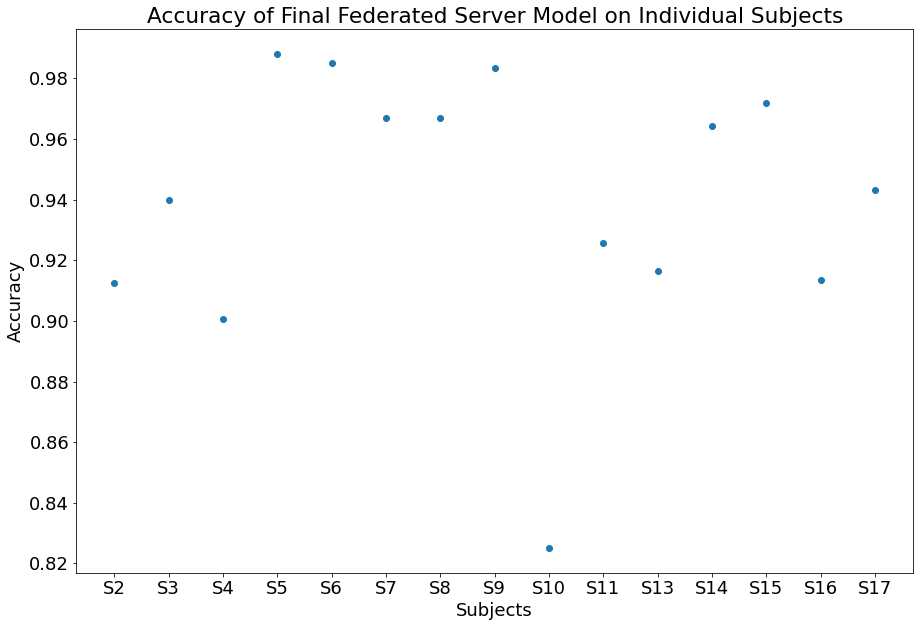

In [110]:
x, y = zip(*sorted(accuracy.items(),key=lambda x: int(x[0][1:])))
plt.scatter(x,y)
plt.xlabel('Subjects')
plt.ylabel('Accuracy')
plt.title('Accuracy of Final Federated Server Model on Individual Subjects')
plt.savefig('Personalized_accuracy.png')

In [117]:
centralized_accuracy = {'S14': 0.9493293591654247,
 'S17': 0.9620991253644315,
 'S15': 0.9791976225854383,
 'S3': 0.9275808936825886,
 'S6': 0.983433734939759,
 'S2': 0.9327073552425665,
 'S4': 0.8667687595712098,
 'S9': 0.9909365558912386,
 'S7': 0.9909502262443439,
 'S13': 0.8998505231689088,
 'S11': 0.9538690476190477,
 'S16': 0.9835820895522388,
 'S5': 0.9850523168908819,
 'S10': 0.9081632653061225,
 'S8': 0.9429429429429429}

In [118]:
accuracy

{'S14': 0.9642324888226528,
 'S17': 0.9431486880466472,
 'S15': 0.9717682020802377,
 'S3': 0.9399075500770416,
 'S6': 0.9849397590361446,
 'S2': 0.9123630672926447,
 'S4': 0.900459418070444,
 'S9': 0.9833836858006042,
 'S7': 0.9668174962292609,
 'S13': 0.9162929745889388,
 'S11': 0.9255952380952381,
 'S16': 0.9134328358208955,
 'S5': 0.9880418535127056,
 'S10': 0.8250728862973761,
 'S8': 0.9669669669669669}

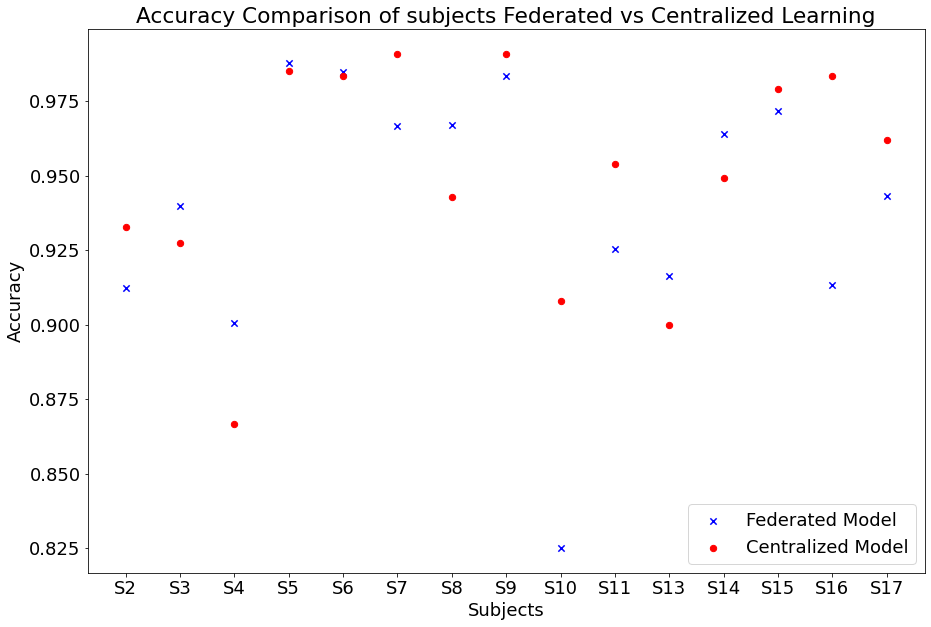

In [133]:
fig = plt.figure()
ax1 = fig.add_subplot()
x1, y1 = zip(*sorted(accuracy.items(),key=lambda x: int(x[0][1:])))
x2, y2 = zip(*sorted(centralized_accuracy.items(),key=lambda x: int(x[0][1:])))
ax1.scatter(x1, y1, s=40, c='b', marker="x", label='Federated Model')
ax1.scatter(x2, y2, s=40, c='r', marker="o", label='Centralized Model')
plt.legend(loc='lower right')
plt.xlabel('Subjects')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison of subjects Federated vs Centralized Learning')
plt.savefig('Federated_Centralizd_model.png')

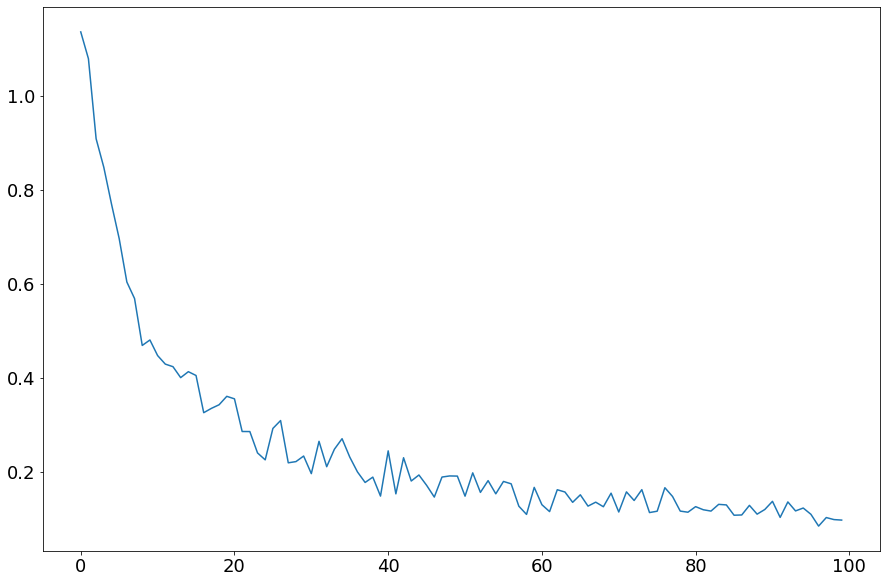

In [48]:
plt.plot(training_metrics['loss'])

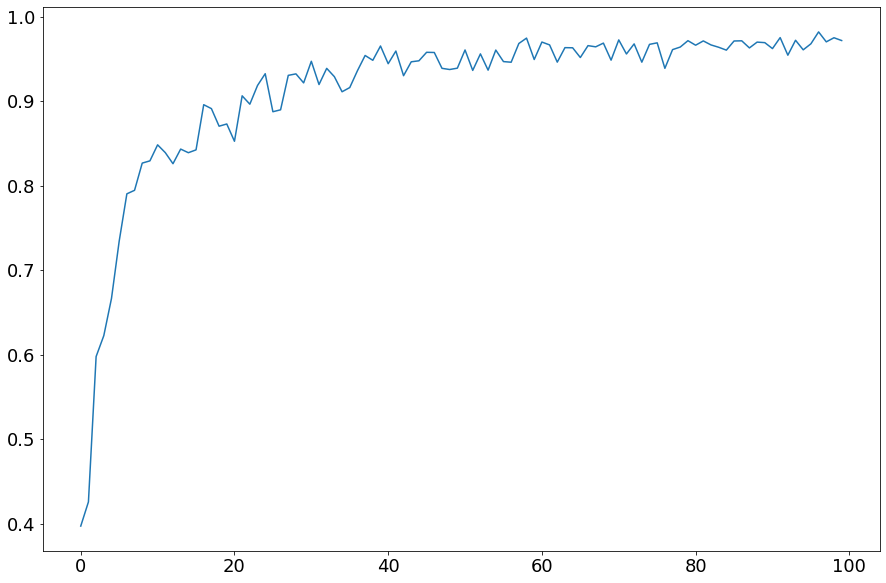

In [49]:
plt.plot(training_metrics['sparse_categorical_accuracy'])

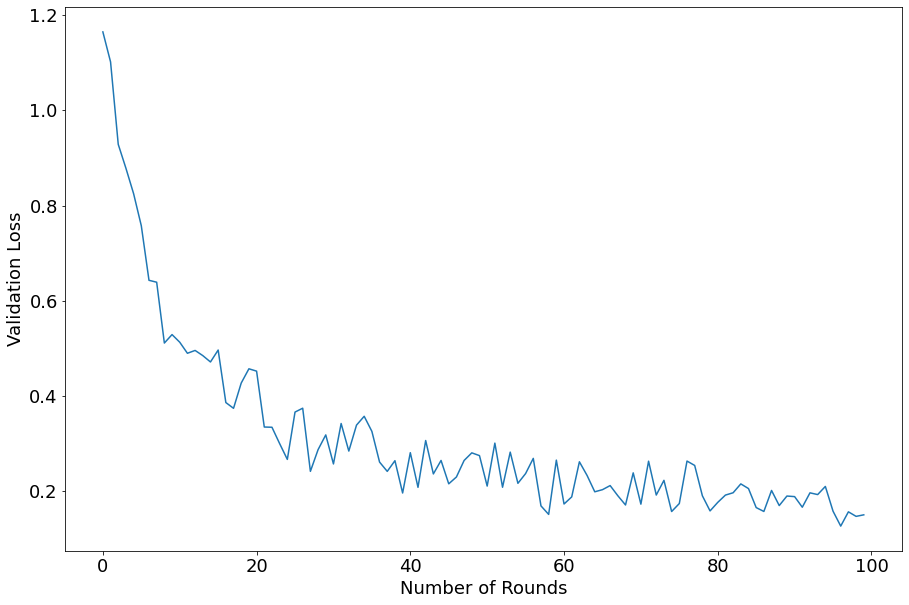

In [50]:
plt.plot(validation_metrics['loss'])
plt.xlabel('Number of Rounds')
plt.ylabel('Validation Loss')
plt.savefig('Validation_loss.png')

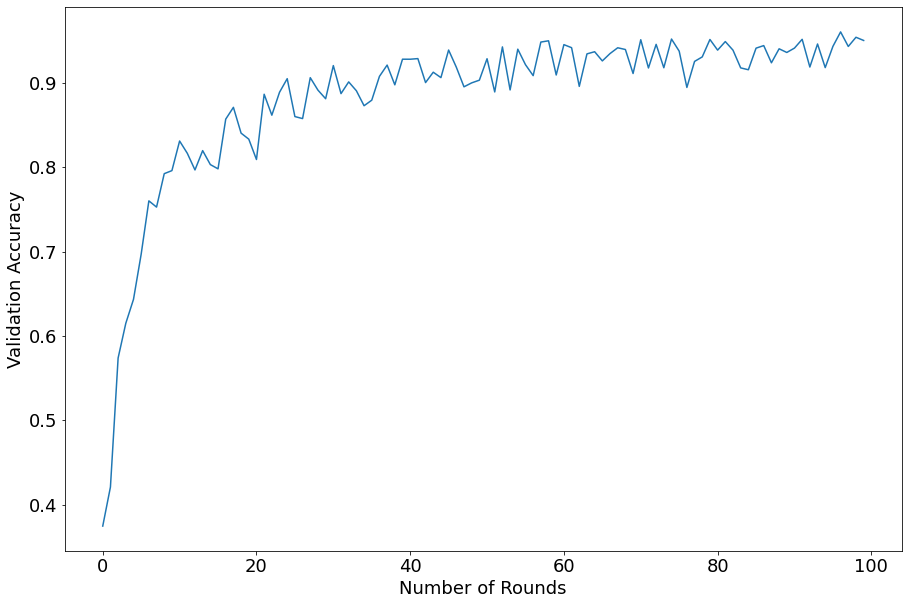

In [51]:
plt.plot(validation_metrics['sparse_categorical_accuracy'])
plt.xlabel('Number of Rounds')
plt.ylabel('Validation Accuracy')
plt.savefig('Validation_accuracy.png')

## Create a Federated Evaluation

In [64]:
federated_evaluation_test = tff.learning.build_federated_evaluation(model_fn)

In [65]:
model_fn()

In [66]:
model_weights = federated_training.get_model_weights(state)
federated_test_data = [
        preprocess_fn(tff_dataset_test.create_tf_dataset_for_client(c), train=False) for c in tff_dataset_test.client_ids
      ]
federated_evaluation_test(model_weights,federated_test_data)

OrderedDict([('eval',
              OrderedDict([('sparse_categorical_accuracy', 0.94005203),
                           ('loss', 0.18469264),
                           ('num_examples', 29976),
                           ('num_batches', 1880)]))])

In [67]:
keras_model = create_keras_model()
model_weights = federated_training.get_model_weights(state)

In [68]:
# keras_model.set_weights(model_weights)

In [69]:
model_weights.assign_weights_to(keras_model)

In [70]:
# keras

In [71]:
y_preds = np.argmax(keras_model.predict(X_test), axis=-1)

21/21 [==============================] - 0s 1ms/step


In [ ]:
y_preds = label_binarize(y_preds, classes=[0,1,2])
y_test = label_binarize(y_test, classes=[0,1,2])

In [ ]:
y_preds = np.argmax(y_preds, axis=-1)
y_test = np.argmax(y_test, axis=-1)

In [ ]:
y_test.shape

In [ ]:
fpr = dict()
tpr = dict()
roc_auc = dict()
lw=2
n_classes =3
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_preds[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.savefig('ROC_AUC-Curve.png')

In [ ]:
target_names = ['Neutral', 'Stress', 'Amusement']
pd.DataFrame(classification_report(y_test, y_preds, target_names=target_names, output_dict=True)).transpose()

In [ ]:
cm = confusion_matrix(y_test, y_preds)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
# sns.heatmap(cmn,annot=True, cmap='magma_r')
cmd = ConfusionMatrixDisplay(cmn, display_labels=['Neutral','Stress','Amusement'])
cmd.plot(cmap='magma_r')

# plt.xlabel('Predicted Class')
# plt.ylabel('True Class')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png',bbox_inches='tight', dpi=150)

## Differential Privacy using DP SGD Algorithm

* Change Original Fed Avg Algorithm in 2 ways.
* First Client Model Updates are clipped before transmission to server at each round, so as to minimize influence of any one client -- Use Adaptive Clipping
* Second Server must add enough noise to the sum of user updates before averaging to avoid worst case client influence. --  


In [113]:
tff.backends.native.set_local_python_execution_context(clients_per_thread=1)
rounds = 100
# clients_per_round = 10
# noise_multipliers = [0.0, 0.25, 0.5, 0.75]

In [114]:
noise_multipliers = [.75]
# noise_multiplier =0.25
clients_per_round = 8
# tff.learning.model_update_aggregator.dp_aggregator(noise_multiplier,clients_per_round)

In [115]:
training_metrics_dp = collections.defaultdict(list)
validation_metrics_dp = collections.defaultdict(list)
test_metrics_dp = collections.defaultdict(list)
train_df = pd.DataFrame()
valid_df = pd.DataFrame()
test_df = pd.DataFrame()

NUM_ROUNDS = 100

for noise_multiplier in noise_multipliers:
    
    #Define technique for model parameter aggregation
    aggregation_factory = tff.learning.model_update_aggregator.dp_aggregator(noise_multiplier, clients_per_round)
    
    #Define learning algorithm for federated training
    federated_training_dp = tff.learning.algorithms.build_unweighted_fed_avg(
            model_fn,
            client_optimizer_fn=lambda: tf.keras.optimizers.SGD(0.0001),
            server_optimizer_fn=lambda: tf.keras.optimizers.SGD(1.0, momentum=0.9),
            model_aggregator=aggregation_factory)
    
    #Initialize federated training
    state = federated_training_dp.initialize()
    
    print(f'Starting training with noise multiplier: {noise_multiplier}')
    for round_num in range(1,NUM_ROUNDS):
        
        # Randomly sample clients from available clients for training
        participating_clients = np.random.choice(tff_dataset_train.client_ids,size=clients_per_round)
        federated_train_data = [
            preprocess_fn(tff_dataset_train.create_tf_dataset_for_client(c),train=True) for c in participating_clients
          ]
        result = federated_training_dp.next(state, federated_train_data)
        metrics = result.metrics
        state = result.state
        print('round {:2d}, metrics={}'.format(round_num, metrics))

        #Create and append training metrics of this round to dataframe
        training_metrics_dp['loss'] = metrics.get('client_work', {}).get('train', {}).get('loss')
        training_metrics_dp['sparse_categorical_accuracy'] = metrics.get('client_work', {}).get('train', {}).get('sparse_categorical_accuracy')
        training_metrics_dp['round_num'] = round_num
        training_metrics_dp['noise_multiplier'] = noise_multiplier
        train_df = train_df.append(training_metrics_dp, ignore_index=True)
        
        #Create federated evaluation to test trained server model on validation data from participating clients
        federated_validation_dp = tff.learning.build_federated_evaluation(model_fn)
        federated_validation_data = [
            preprocess_fn(tff_dataset_valid.create_tf_dataset_for_client(c), train=False) for c in participating_clients
          ]
        model_weights = federated_training_dp.get_model_weights(state)
        eval_result = federated_validation_dp(model_weights, federated_validation_data)

        #Create and Append Validation metrics to validation dataframe
        validation_metrics_dp['loss'] = eval_result.get('eval', {}).get('loss')
        validation_metrics_dp['sparse_categorical_accuracy'] = eval_result.get('eval', {}).get('sparse_categorical_accuracy')
        validation_metrics_dp['round_num'] = round_num
        validation_metrics_dp['noise_multiplier'] = noise_multiplier
        valid_df = valid_df.append(validation_metrics_dp, ignore_index=True)

        print('round {:2d}, evaluation metrics={}'.format(round_num, eval_result))
        print("\n")
    
    #Test final model on hold out test data for each noise multiplier
    model_weights = federated_training_dp.get_model_weights(state)
    federated_test_data = [
            preprocess_fn(tff_dataset_test.create_tf_dataset_for_client(c), train=False) for c in tff_dataset_test.client_ids
          ]
    federated_testing_dp = tff.learning.build_federated_evaluation(model_fn)
    test_result = federated_testing_dp(model_weights,federated_test_data)
    test_metrics_dp['loss'] = test_result.get('eval', {}).get('loss')
    test_metrics_dp['sparse_categorical_accuracy'] = test_result.get('eval', {}).get('sparse_categorical_accuracy')
    test_df = test_df.append(test_metrics_dp, ignore_index=True)


Starting training with noise multiplier: 0.75
round  1, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.20218638), ('loss', 1.1904644), ('num_examples', 28083), ('num_batches', 1758)]))])), ('aggregator', OrderedDict([('zeroing', OrderedDict([('dp_query_metrics', OrderedDict([('clip', 0.09051898)])), ('dp', ())])), ('zeroing_norm', 21.0), ('zeroed_count', 0)])), ('finalizer', ())])


/tmp/ipykernel_49467/3924068837.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(training_metrics_dp, ignore_index=True)
/tmp/ipykernel_49467/3924068837.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  valid_df = valid_df.append(validation_metrics_dp, ignore_index=True)


round  1, evaluation metrics=OrderedDict([('eval', OrderedDict([('sparse_categorical_accuracy', 0.19929622), ('loss', 1.2278693), ('num_examples', 9378), ('num_batches', 590)]))])


round  2, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.2549585), ('loss', 1.1864498), ('num_examples', 28083), ('num_batches', 1760)]))])), ('aggregator', OrderedDict([('zeroing', OrderedDict([('dp_query_metrics', OrderedDict([('clip', 0.08338059)])), ('dp', ())])), ('zeroing_norm', 20.099854), ('zeroed_count', 0)])), ('finalizer', ())])


/tmp/ipykernel_49467/3924068837.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(training_metrics_dp, ignore_index=True)
/tmp/ipykernel_49467/3924068837.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  valid_df = valid_df.append(validation_metrics_dp, ignore_index=True)


round  2, evaluation metrics=OrderedDict([('eval', OrderedDict([('sparse_categorical_accuracy', 0.2224), ('loss', 1.2477833), ('num_examples', 9375), ('num_batches', 589)]))])


round  3, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.18519312), ('loss', 1.3391876), ('num_examples', 27987), ('num_batches', 1752)]))])), ('aggregator', OrderedDict([('zeroing', OrderedDict([('dp_query_metrics', OrderedDict([('clip', 0.07566616)])), ('dp', ())])), ('zeroing_norm', 19.24022), ('zeroed_count', 0)])), ('finalizer', ())])


/tmp/ipykernel_49467/3924068837.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(training_metrics_dp, ignore_index=True)
/tmp/ipykernel_49467/3924068837.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  valid_df = valid_df.append(validation_metrics_dp, ignore_index=True)


round  3, evaluation metrics=OrderedDict([('eval', OrderedDict([('sparse_categorical_accuracy', 0.17185993), ('loss', 1.4341251), ('num_examples', 9339), ('num_batches', 586)]))])


round  4, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.1876115), ('loss', 1.3202193), ('num_examples', 28026), ('num_batches', 1755)]))])), ('aggregator', OrderedDict([('zeroing', OrderedDict([('dp_query_metrics', OrderedDict([('clip', 0.068465576)])), ('dp', ())])), ('zeroing_norm', 18.419275), ('zeroed_count', 0)])), ('finalizer', ())])


/tmp/ipykernel_49467/3924068837.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(training_metrics_dp, ignore_index=True)
/tmp/ipykernel_49467/3924068837.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  valid_df = valid_df.append(validation_metrics_dp, ignore_index=True)


round  4, evaluation metrics=OrderedDict([('eval', OrderedDict([('sparse_categorical_accuracy', 0.20782553), ('loss', 1.3314308), ('num_examples', 9354), ('num_batches', 589)]))])


round  5, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.20260534), ('loss', 1.3188127), ('num_examples', 28173), ('num_batches', 1764)]))])), ('aggregator', OrderedDict([('zeroing', OrderedDict([('dp_query_metrics', OrderedDict([('clip', 0.061950214)])), ('dp', ())])), ('zeroing_norm', 17.63528), ('zeroed_count', 0)])), ('finalizer', ())])


/tmp/ipykernel_49467/3924068837.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(training_metrics_dp, ignore_index=True)
/tmp/ipykernel_49467/3924068837.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  valid_df = valid_df.append(validation_metrics_dp, ignore_index=True)


round  5, evaluation metrics=OrderedDict([('eval', OrderedDict([('sparse_categorical_accuracy', 0.23548181), ('loss', 1.3698525), ('num_examples', 9402), ('num_batches', 591)]))])


round  6, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.19314376), ('loss', 1.426506), ('num_examples', 28062), ('num_batches', 1758)]))])), ('aggregator', OrderedDict([('zeroing', OrderedDict([('dp_query_metrics', OrderedDict([('clip', 0.05630457)])), ('dp', ())])), ('zeroing_norm', 16.88657), ('zeroed_count', 0)])), ('finalizer', ())])


/tmp/ipykernel_49467/3924068837.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(training_metrics_dp, ignore_index=True)
/tmp/ipykernel_49467/3924068837.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  valid_df = valid_df.append(validation_metrics_dp, ignore_index=True)


round  6, evaluation metrics=OrderedDict([('eval', OrderedDict([('sparse_categorical_accuracy', 0.23518103), ('loss', 1.4960115), ('num_examples', 9363), ('num_batches', 589)]))])


round  7, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.2955323), ('loss', 1.3152288), ('num_examples', 27777), ('num_batches', 1739)]))])), ('aggregator', OrderedDict([('zeroing', OrderedDict([('dp_query_metrics', OrderedDict([('clip', 0.051617652)])), ('dp', ())])), ('zeroing_norm', 16.171558), ('zeroed_count', 0)])), ('finalizer', ())])


/tmp/ipykernel_49467/3924068837.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(training_metrics_dp, ignore_index=True)
/tmp/ipykernel_49467/3924068837.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  valid_df = valid_df.append(validation_metrics_dp, ignore_index=True)


round  7, evaluation metrics=OrderedDict([('eval', OrderedDict([('sparse_categorical_accuracy', 0.31521034), ('loss', 1.4472289), ('num_examples', 9270), ('num_batches', 583)]))])


round  8, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.34158838), ('loss', 1.3100923), ('num_examples', 28104), ('num_batches', 1761)]))])), ('aggregator', OrderedDict([('zeroing', OrderedDict([('dp_query_metrics', OrderedDict([('clip', 0.04919624)])), ('dp', ())])), ('zeroing_norm', 15.488727), ('zeroed_count', 0)])), ('finalizer', ())])


/tmp/ipykernel_49467/3924068837.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(training_metrics_dp, ignore_index=True)
/tmp/ipykernel_49467/3924068837.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  valid_df = valid_df.append(validation_metrics_dp, ignore_index=True)


round  8, evaluation metrics=OrderedDict([('eval', OrderedDict([('sparse_categorical_accuracy', 0.33152175), ('loss', 1.4648346), ('num_examples', 9384), ('num_batches', 590)]))])


round  9, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.3801394), ('loss', 1.2128882), ('num_examples', 28116), ('num_batches', 1761)]))])), ('aggregator', OrderedDict([('zeroing', OrderedDict([('dp_query_metrics', OrderedDict([('clip', 0.04510802)])), ('dp', ())])), ('zeroing_norm', 14.836627), ('zeroed_count', 0)])), ('finalizer', ())])


/tmp/ipykernel_49467/3924068837.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(training_metrics_dp, ignore_index=True)
/tmp/ipykernel_49467/3924068837.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  valid_df = valid_df.append(validation_metrics_dp, ignore_index=True)


round  9, evaluation metrics=OrderedDict([('eval', OrderedDict([('sparse_categorical_accuracy', 0.42130518), ('loss', 1.2562336), ('num_examples', 9378), ('num_batches', 590)]))])


round 10, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.44715446), ('loss', 1.3569765), ('num_examples', 28044), ('num_batches', 1756)]))])), ('aggregator', OrderedDict([('zeroing', OrderedDict([('dp_query_metrics', OrderedDict([('clip', 0.044761278)])), ('dp', ())])), ('zeroing_norm', 14.213877), ('zeroed_count', 0)])), ('finalizer', ())])


/tmp/ipykernel_49467/3924068837.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(training_metrics_dp, ignore_index=True)
/tmp/ipykernel_49467/3924068837.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  valid_df = valid_df.append(validation_metrics_dp, ignore_index=True)


round 10, evaluation metrics=OrderedDict([('eval', OrderedDict([('sparse_categorical_accuracy', 0.4871795), ('loss', 1.4569278), ('num_examples', 9360), ('num_batches', 589)]))])


round 11, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.4886773), ('loss', 1.2307049), ('num_examples', 28041), ('num_batches', 1756)]))])), ('aggregator', OrderedDict([('zeroing', OrderedDict([('dp_query_metrics', OrderedDict([('clip', 0.043469764)])), ('dp', ())])), ('zeroing_norm', 13.619155), ('zeroed_count', 0)])), ('finalizer', ())])


/tmp/ipykernel_49467/3924068837.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(training_metrics_dp, ignore_index=True)
/tmp/ipykernel_49467/3924068837.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  valid_df = valid_df.append(validation_metrics_dp, ignore_index=True)


round 11, evaluation metrics=OrderedDict([('eval', OrderedDict([('sparse_categorical_accuracy', 0.50801283), ('loss', 1.2305447), ('num_examples', 9360), ('num_batches', 588)]))])


round 12, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.48443294), ('loss', 1.3142377), ('num_examples', 27783), ('num_batches', 1740)]))])), ('aggregator', OrderedDict([('zeroing', OrderedDict([('dp_query_metrics', OrderedDict([('clip', 0.04561427)])), ('dp', ())])), ('zeroing_norm', 13.0512), ('zeroed_count', 0)])), ('finalizer', ())])


/tmp/ipykernel_49467/3924068837.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(training_metrics_dp, ignore_index=True)
/tmp/ipykernel_49467/3924068837.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  valid_df = valid_df.append(validation_metrics_dp, ignore_index=True)


round 12, evaluation metrics=OrderedDict([('eval', OrderedDict([('sparse_categorical_accuracy', 0.5027499), ('loss', 1.3017998), ('num_examples', 9273), ('num_batches', 582)]))])


round 13, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.53389525), ('loss', 1.3237998), ('num_examples', 27762), ('num_batches', 1739)]))])), ('aggregator', OrderedDict([('zeroing', OrderedDict([('dp_query_metrics', OrderedDict([('clip', 0.04421541)])), ('dp', ())])), ('zeroing_norm', 12.508807), ('zeroed_count', 0)])), ('finalizer', ())])


/tmp/ipykernel_49467/3924068837.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(training_metrics_dp, ignore_index=True)
/tmp/ipykernel_49467/3924068837.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  valid_df = valid_df.append(validation_metrics_dp, ignore_index=True)


round 13, evaluation metrics=OrderedDict([('eval', OrderedDict([('sparse_categorical_accuracy', 0.55893785), ('loss', 1.3859254), ('num_examples', 9264), ('num_batches', 583)]))])


round 14, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.5710715), ('loss', 1.1889817), ('num_examples', 27606), ('num_batches', 1729)]))])), ('aggregator', OrderedDict([('zeroing', OrderedDict([('dp_query_metrics', OrderedDict([('clip', 0.043959472)])), ('dp', ())])), ('zeroing_norm', 11.990827), ('zeroed_count', 0)])), ('finalizer', ())])


/tmp/ipykernel_49467/3924068837.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(training_metrics_dp, ignore_index=True)
/tmp/ipykernel_49467/3924068837.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  valid_df = valid_df.append(validation_metrics_dp, ignore_index=True)


round 14, evaluation metrics=OrderedDict([('eval', OrderedDict([('sparse_categorical_accuracy', 0.58723956), ('loss', 1.2055429), ('num_examples', 9216), ('num_batches', 580)]))])


round 15, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.5960114), ('loss', 1.0814985), ('num_examples', 28080), ('num_batches', 1758)]))])), ('aggregator', OrderedDict([('zeroing', OrderedDict([('dp_query_metrics', OrderedDict([('clip', 0.044183835)])), ('dp', ())])), ('zeroing_norm', 11.496159), ('zeroed_count', 0)])), ('finalizer', ())])


/tmp/ipykernel_49467/3924068837.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(training_metrics_dp, ignore_index=True)
/tmp/ipykernel_49467/3924068837.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  valid_df = valid_df.append(validation_metrics_dp, ignore_index=True)


round 15, evaluation metrics=OrderedDict([('eval', OrderedDict([('sparse_categorical_accuracy', 0.596862), ('loss', 1.1363418), ('num_examples', 9369), ('num_batches', 589)]))])


round 16, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.6412405), ('loss', 1.1926607), ('num_examples', 27570), ('num_batches', 1726)]))])), ('aggregator', OrderedDict([('zeroing', OrderedDict([('dp_query_metrics', OrderedDict([('clip', 0.044497482)])), ('dp', ())])), ('zeroing_norm', 11.023754), ('zeroed_count', 0)])), ('finalizer', ())])


/tmp/ipykernel_49467/3924068837.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(training_metrics_dp, ignore_index=True)
/tmp/ipykernel_49467/3924068837.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  valid_df = valid_df.append(validation_metrics_dp, ignore_index=True)


round 16, evaluation metrics=OrderedDict([('eval', OrderedDict([('sparse_categorical_accuracy', 0.64146024), ('loss', 1.3174365), ('num_examples', 9204), ('num_batches', 579)]))])


round 17, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.67069167), ('loss', 1.0579827), ('num_examples', 28323), ('num_batches', 1773)]))])), ('aggregator', OrderedDict([('zeroing', OrderedDict([('dp_query_metrics', OrderedDict([('clip', 0.044235546)])), ('dp', ())])), ('zeroing_norm', 10.572612), ('zeroed_count', 0)])), ('finalizer', ())])


/tmp/ipykernel_49467/3924068837.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(training_metrics_dp, ignore_index=True)
/tmp/ipykernel_49467/3924068837.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  valid_df = valid_df.append(validation_metrics_dp, ignore_index=True)


round 17, evaluation metrics=OrderedDict([('eval', OrderedDict([('sparse_categorical_accuracy', 0.6976818), ('loss', 1.1465101), ('num_examples', 9447), ('num_batches', 594)]))])


round 18, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.65194285), ('loss', 1.178879), ('num_examples', 27846), ('num_batches', 1745)]))])), ('aggregator', OrderedDict([('zeroing', OrderedDict([('dp_query_metrics', OrderedDict([('clip', 0.04770371)])), ('dp', ())])), ('zeroing_norm', 10.141774), ('zeroed_count', 0)])), ('finalizer', ())])


/tmp/ipykernel_49467/3924068837.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(training_metrics_dp, ignore_index=True)
/tmp/ipykernel_49467/3924068837.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  valid_df = valid_df.append(validation_metrics_dp, ignore_index=True)


round 18, evaluation metrics=OrderedDict([('eval', OrderedDict([('sparse_categorical_accuracy', 0.6323435), ('loss', 1.285302), ('num_examples', 9294), ('num_batches', 584)]))])


round 19, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.56629455), ('loss', 1.3829998), ('num_examples', 28215), ('num_batches', 1766)]))])), ('aggregator', OrderedDict([('zeroing', OrderedDict([('dp_query_metrics', OrderedDict([('clip', 0.05131458)])), ('dp', ())])), ('zeroing_norm', 9.730328), ('zeroed_count', 0)])), ('finalizer', ())])


/tmp/ipykernel_49467/3924068837.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(training_metrics_dp, ignore_index=True)
/tmp/ipykernel_49467/3924068837.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  valid_df = valid_df.append(validation_metrics_dp, ignore_index=True)


round 19, evaluation metrics=OrderedDict([('eval', OrderedDict([('sparse_categorical_accuracy', 0.5544586), ('loss', 1.6937428), ('num_examples', 9420), ('num_batches', 591)]))])


round 20, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.78491026), ('loss', 0.8352449), ('num_examples', 27807), ('num_batches', 1742)]))])), ('aggregator', OrderedDict([('zeroing', OrderedDict([('dp_query_metrics', OrderedDict([('clip', 0.047202367)])), ('dp', ())])), ('zeroing_norm', 9.337399), ('zeroed_count', 0)])), ('finalizer', ())])


/tmp/ipykernel_49467/3924068837.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(training_metrics_dp, ignore_index=True)
/tmp/ipykernel_49467/3924068837.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  valid_df = valid_df.append(validation_metrics_dp, ignore_index=True)


round 20, evaluation metrics=OrderedDict([('eval', OrderedDict([('sparse_categorical_accuracy', 0.75831985), ('loss', 0.8920901), ('num_examples', 9285), ('num_batches', 584)]))])


round 21, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.6608571), ('loss', 1.3265024), ('num_examples', 27885), ('num_batches', 1746)]))])), ('aggregator', OrderedDict([('zeroing', OrderedDict([('dp_query_metrics', OrderedDict([('clip', 0.05013425)])), ('dp', ())])), ('zeroing_norm', 8.962154), ('zeroed_count', 0)])), ('finalizer', ())])


/tmp/ipykernel_49467/3924068837.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(training_metrics_dp, ignore_index=True)
/tmp/ipykernel_49467/3924068837.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  valid_df = valid_df.append(validation_metrics_dp, ignore_index=True)


round 21, evaluation metrics=OrderedDict([('eval', OrderedDict([('sparse_categorical_accuracy', 0.62443584), ('loss', 1.5960375), ('num_examples', 9306), ('num_batches', 584)]))])


round 22, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.71870726), ('loss', 0.98110676), ('num_examples', 27786), ('num_batches', 1739)]))])), ('aggregator', OrderedDict([('zeroing', OrderedDict([('dp_query_metrics', OrderedDict([('clip', 0.047782984)])), ('dp', ())])), ('zeroing_norm', 8.603799), ('zeroed_count', 0)])), ('finalizer', ())])


/tmp/ipykernel_49467/3924068837.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(training_metrics_dp, ignore_index=True)
/tmp/ipykernel_49467/3924068837.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  valid_df = valid_df.append(validation_metrics_dp, ignore_index=True)


round 22, evaluation metrics=OrderedDict([('eval', OrderedDict([('sparse_categorical_accuracy', 0.71086675), ('loss', 1.0294877), ('num_examples', 9276), ('num_batches', 583)]))])


round 23, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.7585008), ('loss', 0.934643), ('num_examples', 27909), ('num_batches', 1747)]))])), ('aggregator', OrderedDict([('zeroing', OrderedDict([('dp_query_metrics', OrderedDict([('clip', 0.04573445)])), ('dp', ())])), ('zeroing_norm', 8.261572), ('zeroed_count', 0)])), ('finalizer', ())])


/tmp/ipykernel_49467/3924068837.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(training_metrics_dp, ignore_index=True)
/tmp/ipykernel_49467/3924068837.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  valid_df = valid_df.append(validation_metrics_dp, ignore_index=True)


round 23, evaluation metrics=OrderedDict([('eval', OrderedDict([('sparse_categorical_accuracy', 0.7464562), ('loss', 0.99153334), ('num_examples', 9312), ('num_batches', 587)]))])


round 24, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.75458866), ('loss', 1.0336267), ('num_examples', 27786), ('num_batches', 1739)]))])), ('aggregator', OrderedDict([('zeroing', OrderedDict([('dp_query_metrics', OrderedDict([('clip', 0.046290588)])), ('dp', ())])), ('zeroing_norm', 7.9347477), ('zeroed_count', 0)])), ('finalizer', ())])


/tmp/ipykernel_49467/3924068837.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(training_metrics_dp, ignore_index=True)
/tmp/ipykernel_49467/3924068837.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  valid_df = valid_df.append(validation_metrics_dp, ignore_index=True)


round 24, evaluation metrics=OrderedDict([('eval', OrderedDict([('sparse_categorical_accuracy', 0.72847897), ('loss', 1.2257175), ('num_examples', 9270), ('num_batches', 584)]))])


round 25, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.75033784), ('loss', 1.0326103), ('num_examples', 28122), ('num_batches', 1760)]))])), ('aggregator', OrderedDict([('zeroing', OrderedDict([('dp_query_metrics', OrderedDict([('clip', 0.047812395)])), ('dp', ())])), ('zeroing_norm', 7.622633), ('zeroed_count', 0)])), ('finalizer', ())])


/tmp/ipykernel_49467/3924068837.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(training_metrics_dp, ignore_index=True)
/tmp/ipykernel_49467/3924068837.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  valid_df = valid_df.append(validation_metrics_dp, ignore_index=True)


round 25, evaluation metrics=OrderedDict([('eval', OrderedDict([('sparse_categorical_accuracy', 0.7496803), ('loss', 1.1666666), ('num_examples', 9384), ('num_batches', 591)]))])


round 26, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.75551015), ('loss', 1.1746627), ('num_examples', 27903), ('num_batches', 1747)]))])), ('aggregator', OrderedDict([('zeroing', OrderedDict([('dp_query_metrics', OrderedDict([('clip', 0.047569092)])), ('dp', ())])), ('zeroing_norm', 7.324566), ('zeroed_count', 0)])), ('finalizer', ())])


/tmp/ipykernel_49467/3924068837.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(training_metrics_dp, ignore_index=True)
/tmp/ipykernel_49467/3924068837.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  valid_df = valid_df.append(validation_metrics_dp, ignore_index=True)


round 26, evaluation metrics=OrderedDict([('eval', OrderedDict([('sparse_categorical_accuracy', 0.7271263), ('loss', 1.4370061), ('num_examples', 9312), ('num_batches', 586)]))])


round 27, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.7753219), ('loss', 1.097182), ('num_examples', 27960), ('num_batches', 1752)]))])), ('aggregator', OrderedDict([('zeroing', OrderedDict([('dp_query_metrics', OrderedDict([('clip', 0.046960775)])), ('dp', ())])), ('zeroing_norm', 7.039914), ('zeroed_count', 0)])), ('finalizer', ())])


/tmp/ipykernel_49467/3924068837.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(training_metrics_dp, ignore_index=True)
/tmp/ipykernel_49467/3924068837.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  valid_df = valid_df.append(validation_metrics_dp, ignore_index=True)


round 27, evaluation metrics=OrderedDict([('eval', OrderedDict([('sparse_categorical_accuracy', 0.75321335), ('loss', 1.3491713), ('num_examples', 9336), ('num_batches', 586)]))])


round 28, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.77451515), ('loss', 1.0980939), ('num_examples', 27483), ('num_batches', 1721)]))])), ('aggregator', OrderedDict([('zeroing', OrderedDict([('dp_query_metrics', OrderedDict([('clip', 0.047160607)])), ('dp', ())])), ('zeroing_norm', 6.7680736), ('zeroed_count', 0)])), ('finalizer', ())])


/tmp/ipykernel_49467/3924068837.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(training_metrics_dp, ignore_index=True)
/tmp/ipykernel_49467/3924068837.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  valid_df = valid_df.append(validation_metrics_dp, ignore_index=True)


round 28, evaluation metrics=OrderedDict([('eval', OrderedDict([('sparse_categorical_accuracy', 0.75768477), ('loss', 1.2400041), ('num_examples', 9174), ('num_batches', 577)]))])


round 29, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.751239), ('loss', 0.88999337), ('num_examples', 28248), ('num_batches', 1769)]))])), ('aggregator', OrderedDict([('zeroing', OrderedDict([('dp_query_metrics', OrderedDict([('clip', 0.046894126)])), ('dp', ())])), ('zeroing_norm', 6.5084677), ('zeroed_count', 0)])), ('finalizer', ())])


/tmp/ipykernel_49467/3924068837.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(training_metrics_dp, ignore_index=True)
/tmp/ipykernel_49467/3924068837.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  valid_df = valid_df.append(validation_metrics_dp, ignore_index=True)


round 29, evaluation metrics=OrderedDict([('eval', OrderedDict([('sparse_categorical_accuracy', 0.7272438), ('loss', 0.9662477), ('num_examples', 9426), ('num_batches', 593)]))])


round 30, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.76376194), ('loss', 0.87233585), ('num_examples', 28230), ('num_batches', 1767)]))])), ('aggregator', OrderedDict([('zeroing', OrderedDict([('dp_query_metrics', OrderedDict([('clip', 0.047422256)])), ('dp', ())])), ('zeroing_norm', 6.260546), ('zeroed_count', 0)])), ('finalizer', ())])


/tmp/ipykernel_49467/3924068837.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(training_metrics_dp, ignore_index=True)
/tmp/ipykernel_49467/3924068837.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  valid_df = valid_df.append(validation_metrics_dp, ignore_index=True)


round 30, evaluation metrics=OrderedDict([('eval', OrderedDict([('sparse_categorical_accuracy', 0.73583704), ('loss', 0.92365503), ('num_examples', 9426), ('num_batches', 592)]))])


round 31, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.7592751), ('loss', 0.81338805), ('num_examples', 28086), ('num_batches', 1757)]))])), ('aggregator', OrderedDict([('zeroing', OrderedDict([('dp_query_metrics', OrderedDict([('clip', 0.04651315)])), ('dp', ())])), ('zeroing_norm', 6.023783), ('zeroed_count', 0)])), ('finalizer', ())])


/tmp/ipykernel_49467/3924068837.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(training_metrics_dp, ignore_index=True)
/tmp/ipykernel_49467/3924068837.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  valid_df = valid_df.append(validation_metrics_dp, ignore_index=True)


round 31, evaluation metrics=OrderedDict([('eval', OrderedDict([('sparse_categorical_accuracy', 0.71552), ('loss', 0.9350332), ('num_examples', 9375), ('num_batches', 589)]))])


round 32, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.7910164), ('loss', 0.7299479), ('num_examples', 27873), ('num_batches', 1745)]))])), ('aggregator', OrderedDict([('zeroing', OrderedDict([('dp_query_metrics', OrderedDict([('clip', 0.04516927)])), ('dp', ())])), ('zeroing_norm', 5.797676), ('zeroed_count', 0)])), ('finalizer', ())])


/tmp/ipykernel_49467/3924068837.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(training_metrics_dp, ignore_index=True)
/tmp/ipykernel_49467/3924068837.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  valid_df = valid_df.append(validation_metrics_dp, ignore_index=True)


round 32, evaluation metrics=OrderedDict([('eval', OrderedDict([('sparse_categorical_accuracy', 0.75435203), ('loss', 0.8657549), ('num_examples', 9306), ('num_batches', 586)]))])


round 33, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.7197576), ('loss', 1.0622803), ('num_examples', 27726), ('num_batches', 1736)]))])), ('aggregator', OrderedDict([('zeroing', OrderedDict([('dp_query_metrics', OrderedDict([('clip', 0.045984272)])), ('dp', ())])), ('zeroing_norm', 5.5817456), ('zeroed_count', 0)])), ('finalizer', ())])


/tmp/ipykernel_49467/3924068837.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(training_metrics_dp, ignore_index=True)
/tmp/ipykernel_49467/3924068837.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  valid_df = valid_df.append(validation_metrics_dp, ignore_index=True)


round 33, evaluation metrics=OrderedDict([('eval', OrderedDict([('sparse_categorical_accuracy', 0.6700162), ('loss', 1.3131101), ('num_examples', 9255), ('num_batches', 582)]))])


round 34, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.7074384), ('loss', 1.1538544), ('num_examples', 27936), ('num_batches', 1749)]))])), ('aggregator', OrderedDict([('zeroing', OrderedDict([('dp_query_metrics', OrderedDict([('clip', 0.04882828)])), ('dp', ())])), ('zeroing_norm', 5.3755336), ('zeroed_count', 0)])), ('finalizer', ())])


/tmp/ipykernel_49467/3924068837.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(training_metrics_dp, ignore_index=True)
/tmp/ipykernel_49467/3924068837.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  valid_df = valid_df.append(validation_metrics_dp, ignore_index=True)


round 34, evaluation metrics=OrderedDict([('eval', OrderedDict([('sparse_categorical_accuracy', 0.6835158), ('loss', 1.3119966), ('num_examples', 9318), ('num_batches', 587)]))])


round 35, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.7528122), ('loss', 0.9720126), ('num_examples', 27825), ('num_batches', 1744)]))])), ('aggregator', OrderedDict([('zeroing', OrderedDict([('dp_query_metrics', OrderedDict([('clip', 0.050614156)])), ('dp', ())])), ('zeroing_norm', 5.178602), ('zeroed_count', 0)])), ('finalizer', ())])


/tmp/ipykernel_49467/3924068837.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(training_metrics_dp, ignore_index=True)
/tmp/ipykernel_49467/3924068837.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  valid_df = valid_df.append(validation_metrics_dp, ignore_index=True)


round 35, evaluation metrics=OrderedDict([('eval', OrderedDict([('sparse_categorical_accuracy', 0.74362284), ('loss', 1.0485605), ('num_examples', 9291), ('num_batches', 585)]))])


round 36, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.75787675), ('loss', 0.8125468), ('num_examples', 28089), ('num_batches', 1759)]))])), ('aggregator', OrderedDict([('zeroing', OrderedDict([('dp_query_metrics', OrderedDict([('clip', 0.048303664)])), ('dp', ())])), ('zeroing_norm', 4.9905343), ('zeroed_count', 0)])), ('finalizer', ())])


/tmp/ipykernel_49467/3924068837.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(training_metrics_dp, ignore_index=True)
/tmp/ipykernel_49467/3924068837.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  valid_df = valid_df.append(validation_metrics_dp, ignore_index=True)


round 36, evaluation metrics=OrderedDict([('eval', OrderedDict([('sparse_categorical_accuracy', 0.74816), ('loss', 0.85536915), ('num_examples', 9375), ('num_batches', 591)]))])


round 37, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.7482197), ('loss', 1.0764111), ('num_examples', 27945), ('num_batches', 1751)]))])), ('aggregator', OrderedDict([('zeroing', OrderedDict([('dp_query_metrics', OrderedDict([('clip', 0.048964866)])), ('dp', ())])), ('zeroing_norm', 4.810931), ('zeroed_count', 0)])), ('finalizer', ())])


/tmp/ipykernel_49467/3924068837.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(training_metrics_dp, ignore_index=True)
/tmp/ipykernel_49467/3924068837.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  valid_df = valid_df.append(validation_metrics_dp, ignore_index=True)


round 37, evaluation metrics=OrderedDict([('eval', OrderedDict([('sparse_categorical_accuracy', 0.73416907), ('loss', 1.2185177), ('num_examples', 9333), ('num_batches', 588)]))])


round 38, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.7605278), ('loss', 0.82853585), ('num_examples', 28116), ('num_batches', 1763)]))])), ('aggregator', OrderedDict([('zeroing', OrderedDict([('dp_query_metrics', OrderedDict([('clip', 0.047941297)])), ('dp', ())])), ('zeroing_norm', 4.639411), ('zeroed_count', 0)])), ('finalizer', ())])


/tmp/ipykernel_49467/3924068837.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(training_metrics_dp, ignore_index=True)
/tmp/ipykernel_49467/3924068837.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  valid_df = valid_df.append(validation_metrics_dp, ignore_index=True)


round 38, evaluation metrics=OrderedDict([('eval', OrderedDict([('sparse_categorical_accuracy', 0.7516779), ('loss', 0.9934576), ('num_examples', 9387), ('num_batches', 590)]))])


round 39, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.7280294), ('loss', 1.168559), ('num_examples', 28356), ('num_batches', 1776)]))])), ('aggregator', OrderedDict([('zeroing', OrderedDict([('dp_query_metrics', OrderedDict([('clip', 0.051556583)])), ('dp', ())])), ('zeroing_norm', 4.4756107), ('zeroed_count', 0)])), ('finalizer', ())])


/tmp/ipykernel_49467/3924068837.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(training_metrics_dp, ignore_index=True)
/tmp/ipykernel_49467/3924068837.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  valid_df = valid_df.append(validation_metrics_dp, ignore_index=True)


round 39, evaluation metrics=OrderedDict([('eval', OrderedDict([('sparse_categorical_accuracy', 0.7064976), ('loss', 1.327653), ('num_examples', 9465), ('num_batches', 594)]))])


round 40, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.81026524), ('loss', 0.7407564), ('num_examples', 27939), ('num_batches', 1749)]))])), ('aggregator', OrderedDict([('zeroing', OrderedDict([('dp_query_metrics', OrderedDict([('clip', 0.04932285)])), ('dp', ())])), ('zeroing_norm', 4.3191824), ('zeroed_count', 0)])), ('finalizer', ())])


/tmp/ipykernel_49467/3924068837.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(training_metrics_dp, ignore_index=True)
/tmp/ipykernel_49467/3924068837.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  valid_df = valid_df.append(validation_metrics_dp, ignore_index=True)


round 40, evaluation metrics=OrderedDict([('eval', OrderedDict([('sparse_categorical_accuracy', 0.76150626), ('loss', 1.0451703), ('num_examples', 9321), ('num_batches', 587)]))])


round 41, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.74694663), ('loss', 1.0168805), ('num_examples', 28002), ('num_batches', 1753)]))])), ('aggregator', OrderedDict([('zeroing', OrderedDict([('dp_query_metrics', OrderedDict([('clip', 0.049901217)])), ('dp', ())])), ('zeroing_norm', 4.169795), ('zeroed_count', 0)])), ('finalizer', ())])


/tmp/ipykernel_49467/3924068837.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(training_metrics_dp, ignore_index=True)
/tmp/ipykernel_49467/3924068837.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  valid_df = valid_df.append(validation_metrics_dp, ignore_index=True)


round 41, evaluation metrics=OrderedDict([('eval', OrderedDict([('sparse_categorical_accuracy', 0.7210273), ('loss', 1.2358347), ('num_examples', 9345), ('num_batches', 587)]))])


round 42, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.7324992), ('loss', 1.1123232), ('num_examples', 27813), ('num_batches', 1742)]))])), ('aggregator', OrderedDict([('zeroing', OrderedDict([('dp_query_metrics', OrderedDict([('clip', 0.04777189)])), ('dp', ())])), ('zeroing_norm', 4.027131), ('zeroed_count', 0)])), ('finalizer', ())])


/tmp/ipykernel_49467/3924068837.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(training_metrics_dp, ignore_index=True)
/tmp/ipykernel_49467/3924068837.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  valid_df = valid_df.append(validation_metrics_dp, ignore_index=True)


round 42, evaluation metrics=OrderedDict([('eval', OrderedDict([('sparse_categorical_accuracy', 0.7197802), ('loss', 1.3207717), ('num_examples', 9282), ('num_batches', 584)]))])


round 43, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.78110945), ('loss', 0.9476688), ('num_examples', 28014), ('num_batches', 1754)]))])), ('aggregator', OrderedDict([('zeroing', OrderedDict([('dp_query_metrics', OrderedDict([('clip', 0.04623202)])), ('dp', ())])), ('zeroing_norm', 3.890888), ('zeroed_count', 0)])), ('finalizer', ())])


/tmp/ipykernel_49467/3924068837.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(training_metrics_dp, ignore_index=True)
/tmp/ipykernel_49467/3924068837.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  valid_df = valid_df.append(validation_metrics_dp, ignore_index=True)


round 43, evaluation metrics=OrderedDict([('eval', OrderedDict([('sparse_categorical_accuracy', 0.7398974), ('loss', 1.1509457), ('num_examples', 9354), ('num_batches', 589)]))])


round 44, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.75356215), ('loss', 1.1354611), ('num_examples', 27792), ('num_batches', 1741)]))])), ('aggregator', OrderedDict([('zeroing', OrderedDict([('dp_query_metrics', OrderedDict([('clip', 0.04579198)])), ('dp', ())])), ('zeroing_norm', 3.7607768), ('zeroed_count', 0)])), ('finalizer', ())])


/tmp/ipykernel_49467/3924068837.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(training_metrics_dp, ignore_index=True)
/tmp/ipykernel_49467/3924068837.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  valid_df = valid_df.append(validation_metrics_dp, ignore_index=True)


round 44, evaluation metrics=OrderedDict([('eval', OrderedDict([('sparse_categorical_accuracy', 0.7197802), ('loss', 1.3406025), ('num_examples', 9282), ('num_batches', 585)]))])


round 45, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.749964), ('loss', 1.1624354), ('num_examples', 27756), ('num_batches', 1739)]))])), ('aggregator', OrderedDict([('zeroing', OrderedDict([('dp_query_metrics', OrderedDict([('clip', 0.048790347)])), ('dp', ())])), ('zeroing_norm', 3.6365216), ('zeroed_count', 0)])), ('finalizer', ())])


/tmp/ipykernel_49467/3924068837.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(training_metrics_dp, ignore_index=True)
/tmp/ipykernel_49467/3924068837.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  valid_df = valid_df.append(validation_metrics_dp, ignore_index=True)


round 45, evaluation metrics=OrderedDict([('eval', OrderedDict([('sparse_categorical_accuracy', 0.67746115), ('loss', 1.5603087), ('num_examples', 9264), ('num_batches', 584)]))])


round 46, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.678592), ('loss', 1.4140921), ('num_examples', 27756), ('num_batches', 1738)]))])), ('aggregator', OrderedDict([('zeroing', OrderedDict([('dp_query_metrics', OrderedDict([('clip', 0.053382356)])), ('dp', ())])), ('zeroing_norm', 3.5178587), ('zeroed_count', 0)])), ('finalizer', ())])


/tmp/ipykernel_49467/3924068837.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(training_metrics_dp, ignore_index=True)
/tmp/ipykernel_49467/3924068837.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  valid_df = valid_df.append(validation_metrics_dp, ignore_index=True)


round 46, evaluation metrics=OrderedDict([('eval', OrderedDict([('sparse_categorical_accuracy', 0.5942358), ('loss', 1.9679946), ('num_examples', 9264), ('num_batches', 583)]))])


round 47, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.7105538), ('loss', 1.2002158), ('num_examples', 27753), ('num_batches', 1739)]))])), ('aggregator', OrderedDict([('zeroing', OrderedDict([('dp_query_metrics', OrderedDict([('clip', 0.05899663)])), ('dp', ())])), ('zeroing_norm', 3.4045365), ('zeroed_count', 0)])), ('finalizer', ())])


/tmp/ipykernel_49467/3924068837.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(training_metrics_dp, ignore_index=True)
/tmp/ipykernel_49467/3924068837.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  valid_df = valid_df.append(validation_metrics_dp, ignore_index=True)


round 47, evaluation metrics=OrderedDict([('eval', OrderedDict([('sparse_categorical_accuracy', 0.638718), ('loss', 1.5949426), ('num_examples', 9267), ('num_batches', 584)]))])


round 48, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.6693073), ('loss', 1.3884333), ('num_examples', 27645), ('num_batches', 1730)]))])), ('aggregator', OrderedDict([('zeroing', OrderedDict([('dp_query_metrics', OrderedDict([('clip', 0.06502448)])), ('dp', ())])), ('zeroing_norm', 3.2963147), ('zeroed_count', 0)])), ('finalizer', ())])


/tmp/ipykernel_49467/3924068837.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(training_metrics_dp, ignore_index=True)
/tmp/ipykernel_49467/3924068837.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  valid_df = valid_df.append(validation_metrics_dp, ignore_index=True)


round 48, evaluation metrics=OrderedDict([('eval', OrderedDict([('sparse_categorical_accuracy', 0.63405913), ('loss', 1.7766715), ('num_examples', 9231), ('num_batches', 583)]))])


round 49, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.6827093), ('loss', 1.532462), ('num_examples', 27801), ('num_batches', 1741)]))])), ('aggregator', OrderedDict([('zeroing', OrderedDict([('dp_query_metrics', OrderedDict([('clip', 0.06974445)])), ('dp', ())])), ('zeroing_norm', 3.1929636), ('zeroed_count', 0)])), ('finalizer', ())])


/tmp/ipykernel_49467/3924068837.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(training_metrics_dp, ignore_index=True)
/tmp/ipykernel_49467/3924068837.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  valid_df = valid_df.append(validation_metrics_dp, ignore_index=True)


round 49, evaluation metrics=OrderedDict([('eval', OrderedDict([('sparse_categorical_accuracy', 0.65135837), ('loss', 2.0541081), ('num_examples', 9276), ('num_batches', 583)]))])


round 50, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.6709831), ('loss', 1.7919383), ('num_examples', 27801), ('num_batches', 1741)]))])), ('aggregator', OrderedDict([('zeroing', OrderedDict([('dp_query_metrics', OrderedDict([('clip', 0.07252124)])), ('dp', ())])), ('zeroing_norm', 3.094264), ('zeroed_count', 0)])), ('finalizer', ())])


/tmp/ipykernel_49467/3924068837.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(training_metrics_dp, ignore_index=True)
/tmp/ipykernel_49467/3924068837.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  valid_df = valid_df.append(validation_metrics_dp, ignore_index=True)


round 50, evaluation metrics=OrderedDict([('eval', OrderedDict([('sparse_categorical_accuracy', 0.6676366), ('loss', 2.1548526), ('num_examples', 9279), ('num_batches', 584)]))])


round 51, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.7940018), ('loss', 0.96093756), ('num_examples', 27675), ('num_batches', 1732)]))])), ('aggregator', OrderedDict([('zeroing', OrderedDict([('dp_query_metrics', OrderedDict([('clip', 0.07356444)])), ('dp', ())])), ('zeroing_norm', 3.0000067), ('zeroed_count', 0)])), ('finalizer', ())])


/tmp/ipykernel_49467/3924068837.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(training_metrics_dp, ignore_index=True)
/tmp/ipykernel_49467/3924068837.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  valid_df = valid_df.append(validation_metrics_dp, ignore_index=True)


round 51, evaluation metrics=OrderedDict([('eval', OrderedDict([('sparse_categorical_accuracy', 0.7623377), ('loss', 1.2911335), ('num_examples', 9240), ('num_batches', 582)]))])


round 52, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.7145641), ('loss', 1.6076477), ('num_examples', 28227), ('num_batches', 1766)]))])), ('aggregator', OrderedDict([('zeroing', OrderedDict([('dp_query_metrics', OrderedDict([('clip', 0.07099448)])), ('dp', ())])), ('zeroing_norm', 2.9099917), ('zeroed_count', 0)])), ('finalizer', ())])


/tmp/ipykernel_49467/3924068837.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(training_metrics_dp, ignore_index=True)
/tmp/ipykernel_49467/3924068837.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  valid_df = valid_df.append(validation_metrics_dp, ignore_index=True)


round 52, evaluation metrics=OrderedDict([('eval', OrderedDict([('sparse_categorical_accuracy', 0.7066879), ('loss', 1.923275), ('num_examples', 9420), ('num_batches', 592)]))])


round 53, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.8024771), ('loss', 1.225215), ('num_examples', 27855), ('num_batches', 1744)]))])), ('aggregator', OrderedDict([('zeroing', OrderedDict([('dp_query_metrics', OrderedDict([('clip', 0.06756372)])), ('dp', ())])), ('zeroing_norm', 2.824028), ('zeroed_count', 0)])), ('finalizer', ())])


/tmp/ipykernel_49467/3924068837.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(training_metrics_dp, ignore_index=True)
/tmp/ipykernel_49467/3924068837.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  valid_df = valid_df.append(validation_metrics_dp, ignore_index=True)


round 53, evaluation metrics=OrderedDict([('eval', OrderedDict([('sparse_categorical_accuracy', 0.78509194), ('loss', 1.5815072), ('num_examples', 9297), ('num_batches', 585)]))])


round 54, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.751063), ('loss', 1.3349277), ('num_examples', 27987), ('num_batches', 1752)]))])), ('aggregator', OrderedDict([('zeroing', OrderedDict([('dp_query_metrics', OrderedDict([('clip', 0.062003274)])), ('dp', ())])), ('zeroing_norm', 2.7419333), ('zeroed_count', 0)])), ('finalizer', ())])


/tmp/ipykernel_49467/3924068837.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(training_metrics_dp, ignore_index=True)
/tmp/ipykernel_49467/3924068837.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  valid_df = valid_df.append(validation_metrics_dp, ignore_index=True)


round 54, evaluation metrics=OrderedDict([('eval', OrderedDict([('sparse_categorical_accuracy', 0.7202954), ('loss', 1.7391715), ('num_examples', 9342), ('num_batches', 589)]))])


round 55, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.7832701), ('loss', 1.4108944), ('num_examples', 27675), ('num_batches', 1732)]))])), ('aggregator', OrderedDict([('zeroing', OrderedDict([('dp_query_metrics', OrderedDict([('clip', 0.057169467)])), ('dp', ())])), ('zeroing_norm', 2.6635337), ('zeroed_count', 0)])), ('finalizer', ())])


/tmp/ipykernel_49467/3924068837.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(training_metrics_dp, ignore_index=True)
/tmp/ipykernel_49467/3924068837.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  valid_df = valid_df.append(validation_metrics_dp, ignore_index=True)


round 55, evaluation metrics=OrderedDict([('eval', OrderedDict([('sparse_categorical_accuracy', 0.74602145), ('loss', 1.7650027), ('num_examples', 9237), ('num_batches', 583)]))])


round 56, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.77672684), ('loss', 1.2944707), ('num_examples', 27912), ('num_batches', 1747)]))])), ('aggregator', OrderedDict([('zeroing', OrderedDict([('dp_query_metrics', OrderedDict([('clip', 0.052908644)])), ('dp', ())])), ('zeroing_norm', 2.5886624), ('zeroed_count', 0)])), ('finalizer', ())])


/tmp/ipykernel_49467/3924068837.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(training_metrics_dp, ignore_index=True)
/tmp/ipykernel_49467/3924068837.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  valid_df = valid_df.append(validation_metrics_dp, ignore_index=True)


round 56, evaluation metrics=OrderedDict([('eval', OrderedDict([('sparse_categorical_accuracy', 0.724549), ('loss', 1.7161965), ('num_examples', 9312), ('num_batches', 586)]))])


round 57, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.70770544), ('loss', 1.8544824), ('num_examples', 28071), ('num_batches', 1757)]))])), ('aggregator', OrderedDict([('zeroing', OrderedDict([('dp_query_metrics', OrderedDict([('clip', 0.054279596)])), ('dp', ())])), ('zeroing_norm', 2.517161), ('zeroed_count', 0)])), ('finalizer', ())])


/tmp/ipykernel_49467/3924068837.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(training_metrics_dp, ignore_index=True)
/tmp/ipykernel_49467/3924068837.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  valid_df = valid_df.append(validation_metrics_dp, ignore_index=True)


round 57, evaluation metrics=OrderedDict([('eval', OrderedDict([('sparse_categorical_accuracy', 0.6635724), ('loss', 2.2814147), ('num_examples', 9372), ('num_batches', 589)]))])


round 58, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.6705689), ('loss', 2.1533349), ('num_examples', 27933), ('num_batches', 1749)]))])), ('aggregator', OrderedDict([('zeroing', OrderedDict([('dp_query_metrics', OrderedDict([('clip', 0.059988234)])), ('dp', ())])), ('zeroing_norm', 2.4488773), ('zeroed_count', 0)])), ('finalizer', ())])


/tmp/ipykernel_49467/3924068837.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(training_metrics_dp, ignore_index=True)
/tmp/ipykernel_49467/3924068837.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  valid_df = valid_df.append(validation_metrics_dp, ignore_index=True)


round 58, evaluation metrics=OrderedDict([('eval', OrderedDict([('sparse_categorical_accuracy', 0.61216605), ('loss', 2.6700163), ('num_examples', 9321), ('num_batches', 587)]))])


round 59, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.61712825), ('loss', 2.74399), ('num_examples', 27837), ('num_batches', 1743)]))])), ('aggregator', OrderedDict([('zeroing', OrderedDict([('dp_query_metrics', OrderedDict([('clip', 0.066297255)])), ('dp', ())])), ('zeroing_norm', 2.3836675), ('zeroed_count', 0)])), ('finalizer', ())])


/tmp/ipykernel_49467/3924068837.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(training_metrics_dp, ignore_index=True)
/tmp/ipykernel_49467/3924068837.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  valid_df = valid_df.append(validation_metrics_dp, ignore_index=True)


round 59, evaluation metrics=OrderedDict([('eval', OrderedDict([('sparse_categorical_accuracy', 0.5735959), ('loss', 3.390187), ('num_examples', 9294), ('num_batches', 584)]))])


round 60, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.68238497), ('loss', 2.1748471), ('num_examples', 28311), ('num_batches', 1773)]))])), ('aggregator', OrderedDict([('zeroing', OrderedDict([('dp_query_metrics', OrderedDict([('clip', 0.069420226)])), ('dp', ())])), ('zeroing_norm', 2.321392), ('zeroed_count', 0)])), ('finalizer', ())])


/tmp/ipykernel_49467/3924068837.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(training_metrics_dp, ignore_index=True)
/tmp/ipykernel_49467/3924068837.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  valid_df = valid_df.append(validation_metrics_dp, ignore_index=True)


round 60, evaluation metrics=OrderedDict([('eval', OrderedDict([('sparse_categorical_accuracy', 0.6671959), ('loss', 2.4965224), ('num_examples', 9447), ('num_batches', 594)]))])


round 61, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.68718547), ('loss', 2.2335265), ('num_examples', 28218), ('num_batches', 1767)]))])), ('aggregator', OrderedDict([('zeroing', OrderedDict([('dp_query_metrics', OrderedDict([('clip', 0.07427121)])), ('dp', ())])), ('zeroing_norm', 2.26192), ('zeroed_count', 0)])), ('finalizer', ())])


/tmp/ipykernel_49467/3924068837.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(training_metrics_dp, ignore_index=True)
/tmp/ipykernel_49467/3924068837.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  valid_df = valid_df.append(validation_metrics_dp, ignore_index=True)


round 61, evaluation metrics=OrderedDict([('eval', OrderedDict([('sparse_categorical_accuracy', 0.6742038), ('loss', 2.5401788), ('num_examples', 9420), ('num_batches', 592)]))])


round 62, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.73697335), ('loss', 1.9457482), ('num_examples', 28077), ('num_batches', 1759)]))])), ('aggregator', OrderedDict([('zeroing', OrderedDict([('dp_query_metrics', OrderedDict([('clip', 0.07488587)])), ('dp', ())])), ('zeroing_norm', 2.2051241), ('zeroed_count', 0)])), ('finalizer', ())])


/tmp/ipykernel_49467/3924068837.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(training_metrics_dp, ignore_index=True)
/tmp/ipykernel_49467/3924068837.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  valid_df = valid_df.append(validation_metrics_dp, ignore_index=True)


round 62, evaluation metrics=OrderedDict([('eval', OrderedDict([('sparse_categorical_accuracy', 0.73536), ('loss', 2.0944767), ('num_examples', 9375), ('num_batches', 588)]))])


round 63, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.75595945), ('loss', 2.1626735), ('num_examples', 27729), ('num_batches', 1735)]))])), ('aggregator', OrderedDict([('zeroing', OrderedDict([('dp_query_metrics', OrderedDict([('clip', 0.06830399)])), ('dp', ())])), ('zeroing_norm', 2.1508846), ('zeroed_count', 0)])), ('finalizer', ())])


/tmp/ipykernel_49467/3924068837.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(training_metrics_dp, ignore_index=True)
/tmp/ipykernel_49467/3924068837.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  valid_df = valid_df.append(validation_metrics_dp, ignore_index=True)


round 63, evaluation metrics=OrderedDict([('eval', OrderedDict([('sparse_categorical_accuracy', 0.7520259), ('loss', 2.4992933), ('num_examples', 9255), ('num_batches', 582)]))])


round 64, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.7247587), ('loss', 2.7942932), ('num_examples', 27663), ('num_batches', 1732)]))])), ('aggregator', OrderedDict([('zeroing', OrderedDict([('dp_query_metrics', OrderedDict([('clip', 0.06571549)])), ('dp', ())])), ('zeroing_norm', 2.0990865), ('zeroed_count', 0)])), ('finalizer', ())])


/tmp/ipykernel_49467/3924068837.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(training_metrics_dp, ignore_index=True)
/tmp/ipykernel_49467/3924068837.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  valid_df = valid_df.append(validation_metrics_dp, ignore_index=True)


round 64, evaluation metrics=OrderedDict([('eval', OrderedDict([('sparse_categorical_accuracy', 0.7037037), ('loss', 3.0923321), ('num_examples', 9234), ('num_batches', 582)]))])


round 65, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.74380136), ('loss', 2.2128296), ('num_examples', 27990), ('num_batches', 1754)]))])), ('aggregator', OrderedDict([('zeroing', OrderedDict([('dp_query_metrics', OrderedDict([('clip', 0.065914705)])), ('dp', ())])), ('zeroing_norm', 2.0496197), ('zeroed_count', 0)])), ('finalizer', ())])


/tmp/ipykernel_49467/3924068837.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(training_metrics_dp, ignore_index=True)
/tmp/ipykernel_49467/3924068837.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  valid_df = valid_df.append(validation_metrics_dp, ignore_index=True)


round 65, evaluation metrics=OrderedDict([('eval', OrderedDict([('sparse_categorical_accuracy', 0.7124519), ('loss', 2.5223093), ('num_examples', 9348), ('num_batches', 588)]))])


round 66, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.72048074), ('loss', 2.5844827), ('num_examples', 28041), ('num_batches', 1757)]))])), ('aggregator', OrderedDict([('zeroing', OrderedDict([('dp_query_metrics', OrderedDict([('clip', 0.064900756)])), ('dp', ())])), ('zeroing_norm', 2.002379), ('zeroed_count', 0)])), ('finalizer', ())])


/tmp/ipykernel_49467/3924068837.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(training_metrics_dp, ignore_index=True)
/tmp/ipykernel_49467/3924068837.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  valid_df = valid_df.append(validation_metrics_dp, ignore_index=True)


round 66, evaluation metrics=OrderedDict([('eval', OrderedDict([('sparse_categorical_accuracy', 0.7025641), ('loss', 2.8551702), ('num_examples', 9360), ('num_batches', 588)]))])


round 67, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.7327641), ('loss', 2.2197452), ('num_examples', 28110), ('num_batches', 1761)]))])), ('aggregator', OrderedDict([('zeroing', OrderedDict([('dp_query_metrics', OrderedDict([('clip', 0.063440904)])), ('dp', ())])), ('zeroing_norm', 1.9572645), ('zeroed_count', 0)])), ('finalizer', ())])


/tmp/ipykernel_49467/3924068837.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(training_metrics_dp, ignore_index=True)
/tmp/ipykernel_49467/3924068837.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  valid_df = valid_df.append(validation_metrics_dp, ignore_index=True)


round 67, evaluation metrics=OrderedDict([('eval', OrderedDict([('sparse_categorical_accuracy', 0.71099746), ('loss', 2.5195115), ('num_examples', 9384), ('num_batches', 589)]))])


round 68, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.7715083), ('loss', 2.1080353), ('num_examples', 27966), ('num_batches', 1751)]))])), ('aggregator', OrderedDict([('zeroing', OrderedDict([('dp_query_metrics', OrderedDict([('clip', 0.061007917)])), ('dp', ())])), ('zeroing_norm', 1.9141805), ('zeroed_count', 0)])), ('finalizer', ())])


/tmp/ipykernel_49467/3924068837.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(training_metrics_dp, ignore_index=True)
/tmp/ipykernel_49467/3924068837.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  valid_df = valid_df.append(validation_metrics_dp, ignore_index=True)


round 68, evaluation metrics=OrderedDict([('eval', OrderedDict([('sparse_categorical_accuracy', 0.75482005), ('loss', 2.2555642), ('num_examples', 9336), ('num_batches', 587)]))])


round 69, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.7958495), ('loss', 2.038525), ('num_examples', 27852), ('num_batches', 1743)]))])), ('aggregator', OrderedDict([('zeroing', OrderedDict([('dp_query_metrics', OrderedDict([('clip', 0.05906192)])), ('dp', ())])), ('zeroing_norm', 1.8730357), ('zeroed_count', 0)])), ('finalizer', ())])


/tmp/ipykernel_49467/3924068837.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(training_metrics_dp, ignore_index=True)
/tmp/ipykernel_49467/3924068837.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  valid_df = valid_df.append(validation_metrics_dp, ignore_index=True)


round 69, evaluation metrics=OrderedDict([('eval', OrderedDict([('sparse_categorical_accuracy', 0.79761136), ('loss', 1.9286147), ('num_examples', 9294), ('num_batches', 586)]))])


round 70, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.721829), ('loss', 2.7877572), ('num_examples', 27972), ('num_batches', 1752)]))])), ('aggregator', OrderedDict([('zeroing', OrderedDict([('dp_query_metrics', OrderedDict([('clip', 0.062316813)])), ('dp', ())])), ('zeroing_norm', 1.8337426), ('zeroed_count', 0)])), ('finalizer', ())])


/tmp/ipykernel_49467/3924068837.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(training_metrics_dp, ignore_index=True)
/tmp/ipykernel_49467/3924068837.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  valid_df = valid_df.append(validation_metrics_dp, ignore_index=True)


round 70, evaluation metrics=OrderedDict([('eval', OrderedDict([('sparse_categorical_accuracy', 0.72011566), ('loss', 2.7792516), ('num_examples', 9336), ('num_batches', 586)]))])


round 71, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.7902023), ('loss', 2.1434622), ('num_examples', 28170), ('num_batches', 1764)]))])), ('aggregator', OrderedDict([('zeroing', OrderedDict([('dp_query_metrics', OrderedDict([('clip', 0.056386586)])), ('dp', ())])), ('zeroing_norm', 1.7962182), ('zeroed_count', 0)])), ('finalizer', ())])


/tmp/ipykernel_49467/3924068837.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(training_metrics_dp, ignore_index=True)
/tmp/ipykernel_49467/3924068837.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  valid_df = valid_df.append(validation_metrics_dp, ignore_index=True)


round 71, evaluation metrics=OrderedDict([('eval', OrderedDict([('sparse_categorical_accuracy', 0.7727418), ('loss', 2.1815486), ('num_examples', 9399), ('num_batches', 592)]))])


round 72, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.80265945), ('loss', 1.5758588), ('num_examples', 27825), ('num_batches', 1742)]))])), ('aggregator', OrderedDict([('zeroing', OrderedDict([('dp_query_metrics', OrderedDict([('clip', 0.05580861)])), ('dp', ())])), ('zeroing_norm', 1.7603824), ('zeroed_count', 0)])), ('finalizer', ())])


/tmp/ipykernel_49467/3924068837.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(training_metrics_dp, ignore_index=True)
/tmp/ipykernel_49467/3924068837.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  valid_df = valid_df.append(validation_metrics_dp, ignore_index=True)


round 72, evaluation metrics=OrderedDict([('eval', OrderedDict([('sparse_categorical_accuracy', 0.78294575), ('loss', 1.772737), ('num_examples', 9288), ('num_batches', 585)]))])


round 73, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.77760893), ('loss', 1.9808046), ('num_examples', 27636), ('num_batches', 1730)]))])), ('aggregator', OrderedDict([('zeroing', OrderedDict([('dp_query_metrics', OrderedDict([('clip', 0.056228828)])), ('dp', ())])), ('zeroing_norm', 1.7261597), ('zeroed_count', 0)])), ('finalizer', ())])


/tmp/ipykernel_49467/3924068837.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(training_metrics_dp, ignore_index=True)
/tmp/ipykernel_49467/3924068837.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  valid_df = valid_df.append(validation_metrics_dp, ignore_index=True)


round 73, evaluation metrics=OrderedDict([('eval', OrderedDict([('sparse_categorical_accuracy', 0.75707316), ('loss', 2.3039274), ('num_examples', 9225), ('num_batches', 579)]))])


round 74, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.7924353), ('loss', 2.0355213), ('num_examples', 27972), ('num_batches', 1752)]))])), ('aggregator', OrderedDict([('zeroing', OrderedDict([('dp_query_metrics', OrderedDict([('clip', 0.059408363)])), ('dp', ())])), ('zeroing_norm', 1.6934772), ('zeroed_count', 0)])), ('finalizer', ())])


/tmp/ipykernel_49467/3924068837.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(training_metrics_dp, ignore_index=True)
/tmp/ipykernel_49467/3924068837.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  valid_df = valid_df.append(validation_metrics_dp, ignore_index=True)


round 74, evaluation metrics=OrderedDict([('eval', OrderedDict([('sparse_categorical_accuracy', 0.76735216), ('loss', 2.3974261), ('num_examples', 9336), ('num_batches', 587)]))])


round 75, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.80979306), ('loss', 1.8706282), ('num_examples', 28122), ('num_batches', 1762)]))])), ('aggregator', OrderedDict([('zeroing', OrderedDict([('dp_query_metrics', OrderedDict([('clip', 0.05760319)])), ('dp', ())])), ('zeroing_norm', 1.6622655), ('zeroed_count', 0)])), ('finalizer', ())])


/tmp/ipykernel_49467/3924068837.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(training_metrics_dp, ignore_index=True)
/tmp/ipykernel_49467/3924068837.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  valid_df = valid_df.append(validation_metrics_dp, ignore_index=True)


round 75, evaluation metrics=OrderedDict([('eval', OrderedDict([('sparse_categorical_accuracy', 0.7916933), ('loss', 2.1010191), ('num_examples', 9390), ('num_batches', 591)]))])


round 76, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.81179553), ('loss', 1.4644724), ('num_examples', 27858), ('num_batches', 1745)]))])), ('aggregator', OrderedDict([('zeroing', OrderedDict([('dp_query_metrics', OrderedDict([('clip', 0.05470982)])), ('dp', ())])), ('zeroing_norm', 1.6324588), ('zeroed_count', 0)])), ('finalizer', ())])


/tmp/ipykernel_49467/3924068837.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(training_metrics_dp, ignore_index=True)
/tmp/ipykernel_49467/3924068837.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  valid_df = valid_df.append(validation_metrics_dp, ignore_index=True)


round 76, evaluation metrics=OrderedDict([('eval', OrderedDict([('sparse_categorical_accuracy', 0.78967744), ('loss', 1.5908275), ('num_examples', 9300), ('num_batches', 585)]))])


round 77, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.8075344), ('loss', 1.5326858), ('num_examples', 28005), ('num_batches', 1755)]))])), ('aggregator', OrderedDict([('zeroing', OrderedDict([('dp_query_metrics', OrderedDict([('clip', 0.050650746)])), ('dp', ())])), ('zeroing_norm', 1.6039935), ('zeroed_count', 0)])), ('finalizer', ())])


/tmp/ipykernel_49467/3924068837.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(training_metrics_dp, ignore_index=True)
/tmp/ipykernel_49467/3924068837.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  valid_df = valid_df.append(validation_metrics_dp, ignore_index=True)


round 77, evaluation metrics=OrderedDict([('eval', OrderedDict([('sparse_categorical_accuracy', 0.77695763), ('loss', 1.8327396), ('num_examples', 9348), ('num_batches', 588)]))])


round 78, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.81947124), ('loss', 1.561258), ('num_examples', 27990), ('num_batches', 1752)]))])), ('aggregator', OrderedDict([('zeroing', OrderedDict([('dp_query_metrics', OrderedDict([('clip', 0.050605115)])), ('dp', ())])), ('zeroing_norm', 1.5768094), ('zeroed_count', 0)])), ('finalizer', ())])


/tmp/ipykernel_49467/3924068837.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(training_metrics_dp, ignore_index=True)
/tmp/ipykernel_49467/3924068837.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  valid_df = valid_df.append(validation_metrics_dp, ignore_index=True)


round 78, evaluation metrics=OrderedDict([('eval', OrderedDict([('sparse_categorical_accuracy', 0.79743177), ('loss', 1.6477989), ('num_examples', 9345), ('num_batches', 589)]))])


round 79, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.77561045), ('loss', 2.0312247), ('num_examples', 27684), ('num_batches', 1734)]))])), ('aggregator', OrderedDict([('zeroing', OrderedDict([('dp_query_metrics', OrderedDict([('clip', 0.052444857)])), ('dp', ())])), ('zeroing_norm', 1.5508487), ('zeroed_count', 0)])), ('finalizer', ())])


/tmp/ipykernel_49467/3924068837.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(training_metrics_dp, ignore_index=True)
/tmp/ipykernel_49467/3924068837.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  valid_df = valid_df.append(validation_metrics_dp, ignore_index=True)


round 79, evaluation metrics=OrderedDict([('eval', OrderedDict([('sparse_categorical_accuracy', 0.78098637), ('loss', 2.0389855), ('num_examples', 9246), ('num_batches', 583)]))])


round 80, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.7715469), ('loss', 2.392042), ('num_examples', 27765), ('num_batches', 1739)]))])), ('aggregator', OrderedDict([('zeroing', OrderedDict([('dp_query_metrics', OrderedDict([('clip', 0.056155223)])), ('dp', ())])), ('zeroing_norm', 1.5260565), ('zeroed_count', 0)])), ('finalizer', ())])


/tmp/ipykernel_49467/3924068837.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(training_metrics_dp, ignore_index=True)
/tmp/ipykernel_49467/3924068837.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  valid_df = valid_df.append(validation_metrics_dp, ignore_index=True)


round 80, evaluation metrics=OrderedDict([('eval', OrderedDict([('sparse_categorical_accuracy', 0.7754772), ('loss', 2.509436), ('num_examples', 9273), ('num_batches', 584)]))])


round 81, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.79961485), ('loss', 1.8499258), ('num_examples', 28041), ('num_batches', 1756)]))])), ('aggregator', OrderedDict([('zeroing', OrderedDict([('dp_query_metrics', OrderedDict([('clip', 0.058232058)])), ('dp', ())])), ('zeroing_norm', 1.5023801), ('zeroed_count', 0)])), ('finalizer', ())])


/tmp/ipykernel_49467/3924068837.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(training_metrics_dp, ignore_index=True)
/tmp/ipykernel_49467/3924068837.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  valid_df = valid_df.append(validation_metrics_dp, ignore_index=True)


round 81, evaluation metrics=OrderedDict([('eval', OrderedDict([('sparse_categorical_accuracy', 0.77147436), ('loss', 2.2201314), ('num_examples', 9360), ('num_batches', 589)]))])


round 82, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.7975234), ('loss', 1.8102338), ('num_examples', 27618), ('num_batches', 1729)]))])), ('aggregator', OrderedDict([('zeroing', OrderedDict([('dp_query_metrics', OrderedDict([('clip', 0.05930363)])), ('dp', ())])), ('zeroing_norm', 1.4797692), ('zeroed_count', 0)])), ('finalizer', ())])


/tmp/ipykernel_49467/3924068837.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(training_metrics_dp, ignore_index=True)
/tmp/ipykernel_49467/3924068837.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  valid_df = valid_df.append(validation_metrics_dp, ignore_index=True)


round 82, evaluation metrics=OrderedDict([('eval', OrderedDict([('sparse_categorical_accuracy', 0.7734375), ('loss', 2.1990025), ('num_examples', 9216), ('num_batches', 580)]))])


round 83, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.8028204), ('loss', 1.7915784), ('num_examples', 28152), ('num_batches', 1763)]))])), ('aggregator', OrderedDict([('zeroing', OrderedDict([('dp_query_metrics', OrderedDict([('clip', 0.058539078)])), ('dp', ())])), ('zeroing_norm', 1.4581761), ('zeroed_count', 0)])), ('finalizer', ())])


/tmp/ipykernel_49467/3924068837.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(training_metrics_dp, ignore_index=True)
/tmp/ipykernel_49467/3924068837.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  valid_df = valid_df.append(validation_metrics_dp, ignore_index=True)


round 83, evaluation metrics=OrderedDict([('eval', OrderedDict([('sparse_categorical_accuracy', 0.78128994), ('loss', 2.1051192), ('num_examples', 9396), ('num_batches', 591)]))])


round 84, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.7757733), ('loss', 2.4455268), ('num_examples', 27771), ('num_batches', 1740)]))])), ('aggregator', OrderedDict([('zeroing', OrderedDict([('dp_query_metrics', OrderedDict([('clip', 0.058141485)])), ('dp', ())])), ('zeroing_norm', 1.4375548), ('zeroed_count', 0)])), ('finalizer', ())])


/tmp/ipykernel_49467/3924068837.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(training_metrics_dp, ignore_index=True)
/tmp/ipykernel_49467/3924068837.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  valid_df = valid_df.append(validation_metrics_dp, ignore_index=True)


round 84, evaluation metrics=OrderedDict([('eval', OrderedDict([('sparse_categorical_accuracy', 0.7505662), ('loss', 2.8939564), ('num_examples', 9273), ('num_batches', 584)]))])


round 85, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.7894398), ('loss', 2.4105375), ('num_examples', 27954), ('num_batches', 1751)]))])), ('aggregator', OrderedDict([('zeroing', OrderedDict([('dp_query_metrics', OrderedDict([('clip', 0.058163345)])), ('dp', ())])), ('zeroing_norm', 1.4178617), ('zeroed_count', 0)])), ('finalizer', ())])


/tmp/ipykernel_49467/3924068837.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(training_metrics_dp, ignore_index=True)
/tmp/ipykernel_49467/3924068837.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  valid_df = valid_df.append(validation_metrics_dp, ignore_index=True)


round 85, evaluation metrics=OrderedDict([('eval', OrderedDict([('sparse_categorical_accuracy', 0.7701704), ('loss', 2.7299218), ('num_examples', 9333), ('num_batches', 589)]))])


round 86, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.8103723), ('loss', 1.9703698), ('num_examples', 27612), ('num_batches', 1727)]))])), ('aggregator', OrderedDict([('zeroing', OrderedDict([('dp_query_metrics', OrderedDict([('clip', 0.059323423)])), ('dp', ())])), ('zeroing_norm', 1.3990548), ('zeroed_count', 0)])), ('finalizer', ())])


/tmp/ipykernel_49467/3924068837.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(training_metrics_dp, ignore_index=True)
/tmp/ipykernel_49467/3924068837.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  valid_df = valid_df.append(validation_metrics_dp, ignore_index=True)


round 86, evaluation metrics=OrderedDict([('eval', OrderedDict([('sparse_categorical_accuracy', 0.78841144), ('loss', 2.1960948), ('num_examples', 9216), ('num_batches', 581)]))])


round 87, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.7916532), ('loss', 2.1257613), ('num_examples', 27915), ('num_batches', 1749)]))])), ('aggregator', OrderedDict([('zeroing', OrderedDict([('dp_query_metrics', OrderedDict([('clip', 0.062982544)])), ('dp', ())])), ('zeroing_norm', 1.3810945), ('zeroed_count', 0)])), ('finalizer', ())])


/tmp/ipykernel_49467/3924068837.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(training_metrics_dp, ignore_index=True)
/tmp/ipykernel_49467/3924068837.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  valid_df = valid_df.append(validation_metrics_dp, ignore_index=True)


round 87, evaluation metrics=OrderedDict([('eval', OrderedDict([('sparse_categorical_accuracy', 0.777027), ('loss', 2.455249), ('num_examples', 9324), ('num_batches', 588)]))])


round 88, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.78395194), ('loss', 2.2147102), ('num_examples', 27642), ('num_batches', 1731)]))])), ('aggregator', OrderedDict([('zeroing', OrderedDict([('dp_query_metrics', OrderedDict([('clip', 0.060788028)])), ('dp', ())])), ('zeroing_norm', 1.3639424), ('zeroed_count', 0)])), ('finalizer', ())])


/tmp/ipykernel_49467/3924068837.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(training_metrics_dp, ignore_index=True)
/tmp/ipykernel_49467/3924068837.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  valid_df = valid_df.append(validation_metrics_dp, ignore_index=True)


round 88, evaluation metrics=OrderedDict([('eval', OrderedDict([('sparse_categorical_accuracy', 0.76202863), ('loss', 2.475817), ('num_examples', 9228), ('num_batches', 580)]))])


round 89, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.76417726), ('loss', 2.2198534), ('num_examples', 27597), ('num_batches', 1729)]))])), ('aggregator', OrderedDict([('zeroing', OrderedDict([('dp_query_metrics', OrderedDict([('clip', 0.058613416)])), ('dp', ())])), ('zeroing_norm', 1.3475623), ('zeroed_count', 0)])), ('finalizer', ())])


/tmp/ipykernel_49467/3924068837.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(training_metrics_dp, ignore_index=True)
/tmp/ipykernel_49467/3924068837.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  valid_df = valid_df.append(validation_metrics_dp, ignore_index=True)


round 89, evaluation metrics=OrderedDict([('eval', OrderedDict([('sparse_categorical_accuracy', 0.7402344), ('loss', 2.4140418), ('num_examples', 9216), ('num_batches', 580)]))])


round 90, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.78189653), ('loss', 2.0161788), ('num_examples', 27840), ('num_batches', 1743)]))])), ('aggregator', OrderedDict([('zeroing', OrderedDict([('dp_query_metrics', OrderedDict([('clip', 0.057945058)])), ('dp', ())])), ('zeroing_norm', 1.3319194), ('zeroed_count', 0)])), ('finalizer', ())])


/tmp/ipykernel_49467/3924068837.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(training_metrics_dp, ignore_index=True)
/tmp/ipykernel_49467/3924068837.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  valid_df = valid_df.append(validation_metrics_dp, ignore_index=True)


round 90, evaluation metrics=OrderedDict([('eval', OrderedDict([('sparse_categorical_accuracy', 0.7357212), ('loss', 2.4254222), ('num_examples', 9297), ('num_batches', 586)]))])


round 91, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.777958), ('loss', 1.898852), ('num_examples', 27747), ('num_batches', 1738)]))])), ('aggregator', OrderedDict([('zeroing', OrderedDict([('dp_query_metrics', OrderedDict([('clip', 0.06199036)])), ('dp', ())])), ('zeroing_norm', 1.3169806), ('zeroed_count', 0)])), ('finalizer', ())])


/tmp/ipykernel_49467/3924068837.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(training_metrics_dp, ignore_index=True)
/tmp/ipykernel_49467/3924068837.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  valid_df = valid_df.append(validation_metrics_dp, ignore_index=True)


round 91, evaluation metrics=OrderedDict([('eval', OrderedDict([('sparse_categorical_accuracy', 0.6682864), ('loss', 2.5469608), ('num_examples', 9261), ('num_batches', 581)]))])


round 92, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.72995377), ('loss', 2.4071982), ('num_examples', 28110), ('num_batches', 1761)]))])), ('aggregator', OrderedDict([('zeroing', OrderedDict([('dp_query_metrics', OrderedDict([('clip', 0.06850995)])), ('dp', ())])), ('zeroing_norm', 1.3027141), ('zeroed_count', 0)])), ('finalizer', ())])


/tmp/ipykernel_49467/3924068837.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(training_metrics_dp, ignore_index=True)
/tmp/ipykernel_49467/3924068837.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  valid_df = valid_df.append(validation_metrics_dp, ignore_index=True)


round 92, evaluation metrics=OrderedDict([('eval', OrderedDict([('sparse_categorical_accuracy', 0.67018217), ('loss', 2.8056855), ('num_examples', 9387), ('num_batches', 591)]))])


round 93, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.7364266), ('loss', 2.4559195), ('num_examples', 27738), ('num_batches', 1738)]))])), ('aggregator', OrderedDict([('zeroing', OrderedDict([('dp_query_metrics', OrderedDict([('clip', 0.07364538)])), ('dp', ())])), ('zeroing_norm', 1.2890898), ('zeroed_count', 0)])), ('finalizer', ())])


/tmp/ipykernel_49467/3924068837.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(training_metrics_dp, ignore_index=True)
/tmp/ipykernel_49467/3924068837.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  valid_df = valid_df.append(validation_metrics_dp, ignore_index=True)


round 93, evaluation metrics=OrderedDict([('eval', OrderedDict([('sparse_categorical_accuracy', 0.7023964), ('loss', 2.5815182), ('num_examples', 9264), ('num_batches', 582)]))])


round 94, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.7907093), ('loss', 2.053796), ('num_examples', 27942), ('num_batches', 1750)]))])), ('aggregator', OrderedDict([('zeroing', OrderedDict([('dp_query_metrics', OrderedDict([('clip', 0.0734544)])), ('dp', ())])), ('zeroing_norm', 1.2760787), ('zeroed_count', 0)])), ('finalizer', ())])


/tmp/ipykernel_49467/3924068837.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(training_metrics_dp, ignore_index=True)
/tmp/ipykernel_49467/3924068837.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  valid_df = valid_df.append(validation_metrics_dp, ignore_index=True)


round 94, evaluation metrics=OrderedDict([('eval', OrderedDict([('sparse_categorical_accuracy', 0.80540365), ('loss', 2.078427), ('num_examples', 9327), ('num_batches', 587)]))])


round 95, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.75482094), ('loss', 2.2931125), ('num_examples', 27951), ('num_batches', 1751)]))])), ('aggregator', OrderedDict([('zeroing', OrderedDict([('dp_query_metrics', OrderedDict([('clip', 0.07643092)])), ('dp', ())])), ('zeroing_norm', 1.263653), ('zeroed_count', 0)])), ('finalizer', ())])


/tmp/ipykernel_49467/3924068837.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(training_metrics_dp, ignore_index=True)
/tmp/ipykernel_49467/3924068837.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  valid_df = valid_df.append(validation_metrics_dp, ignore_index=True)


round 95, evaluation metrics=OrderedDict([('eval', OrderedDict([('sparse_categorical_accuracy', 0.7124477), ('loss', 2.888257), ('num_examples', 9327), ('num_batches', 587)]))])


round 96, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.76345354), ('loss', 2.4241586), ('num_examples', 28041), ('num_batches', 1756)]))])), ('aggregator', OrderedDict([('zeroing', OrderedDict([('dp_query_metrics', OrderedDict([('clip', 0.07626188)])), ('dp', ())])), ('zeroing_norm', 1.2517867), ('zeroed_count', 0)])), ('finalizer', ())])


/tmp/ipykernel_49467/3924068837.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(training_metrics_dp, ignore_index=True)
/tmp/ipykernel_49467/3924068837.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  valid_df = valid_df.append(validation_metrics_dp, ignore_index=True)


round 96, evaluation metrics=OrderedDict([('eval', OrderedDict([('sparse_categorical_accuracy', 0.7536046), ('loss', 2.7155569), ('num_examples', 9363), ('num_batches', 589)]))])


round 97, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.7774049), ('loss', 2.1622214), ('num_examples', 27714), ('num_batches', 1735)]))])), ('aggregator', OrderedDict([('zeroing', OrderedDict([('dp_query_metrics', OrderedDict([('clip', 0.07164065)])), ('dp', ())])), ('zeroing_norm', 1.2404544), ('zeroed_count', 0)])), ('finalizer', ())])


/tmp/ipykernel_49467/3924068837.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(training_metrics_dp, ignore_index=True)
/tmp/ipykernel_49467/3924068837.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  valid_df = valid_df.append(validation_metrics_dp, ignore_index=True)


round 97, evaluation metrics=OrderedDict([('eval', OrderedDict([('sparse_categorical_accuracy', 0.7522698), ('loss', 2.462769), ('num_examples', 9252), ('num_batches', 582)]))])


round 98, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.8008513), ('loss', 2.017284), ('num_examples', 27723), ('num_batches', 1736)]))])), ('aggregator', OrderedDict([('zeroing', OrderedDict([('dp_query_metrics', OrderedDict([('clip', 0.06984453)])), ('dp', ())])), ('zeroing_norm', 1.2296323), ('zeroed_count', 0)])), ('finalizer', ())])


/tmp/ipykernel_49467/3924068837.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(training_metrics_dp, ignore_index=True)
/tmp/ipykernel_49467/3924068837.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  valid_df = valid_df.append(validation_metrics_dp, ignore_index=True)


round 98, evaluation metrics=OrderedDict([('eval', OrderedDict([('sparse_categorical_accuracy', 0.7687318), ('loss', 2.3794448), ('num_examples', 9249), ('num_batches', 582)]))])


round 99, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.8178624), ('loss', 1.6836525), ('num_examples', 27891), ('num_batches', 1745)]))])), ('aggregator', OrderedDict([('zeroing', OrderedDict([('dp_query_metrics', OrderedDict([('clip', 0.06723376)])), ('dp', ())])), ('zeroing_norm', 1.2192972), ('zeroed_count', 0)])), ('finalizer', ())])


/tmp/ipykernel_49467/3924068837.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(training_metrics_dp, ignore_index=True)
/tmp/ipykernel_49467/3924068837.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  valid_df = valid_df.append(validation_metrics_dp, ignore_index=True)


round 99, evaluation metrics=OrderedDict([('eval', OrderedDict([('sparse_categorical_accuracy', 0.8005799), ('loss', 1.9872545), ('num_examples', 9312), ('num_batches', 586)]))])




/tmp/ipykernel_49467/3924068837.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_df = test_df.append(test_metrics_dp, ignore_index=True)


In [125]:
keras_model = create_keras_model()
model_weights = federated_training_dp.get_model_weights(state)
model_weights.assign_weights_to(keras_model)

In [117]:
test_df

,loss,sparse_categorical_accuracy
0,2.23423,0.782126


In [121]:
# train_df

In [122]:
# 0.782126

In [126]:
keras_model.predict(X_test)

NameError: name 'X_test' is not defined

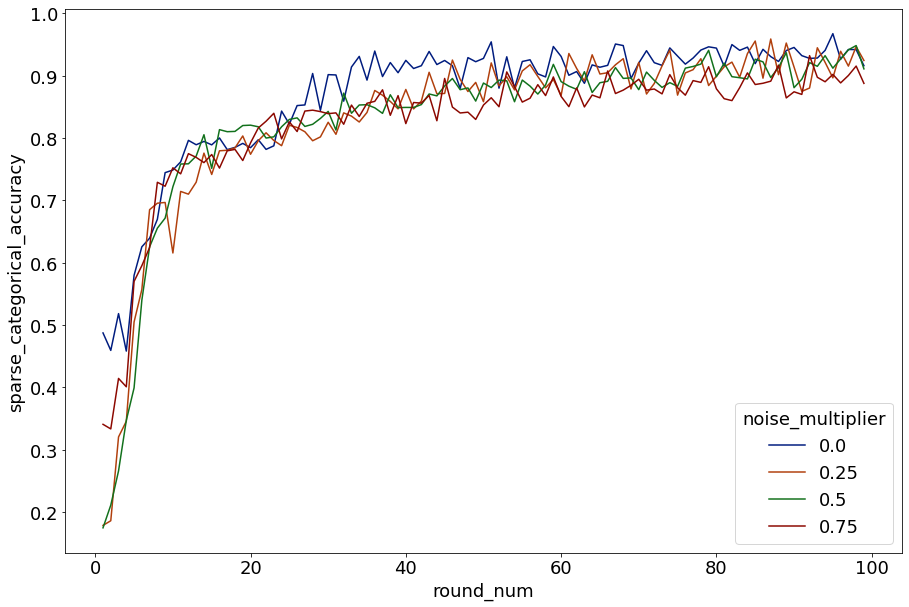

In [24]:
sns_fig = sns.lineplot(data=train_df, x='round_num', y='sparse_categorical_accuracy', hue='noise_multiplier', palette='dark')
sns_fig.figure.savefig('Train_plot_DP_accuracy.png')

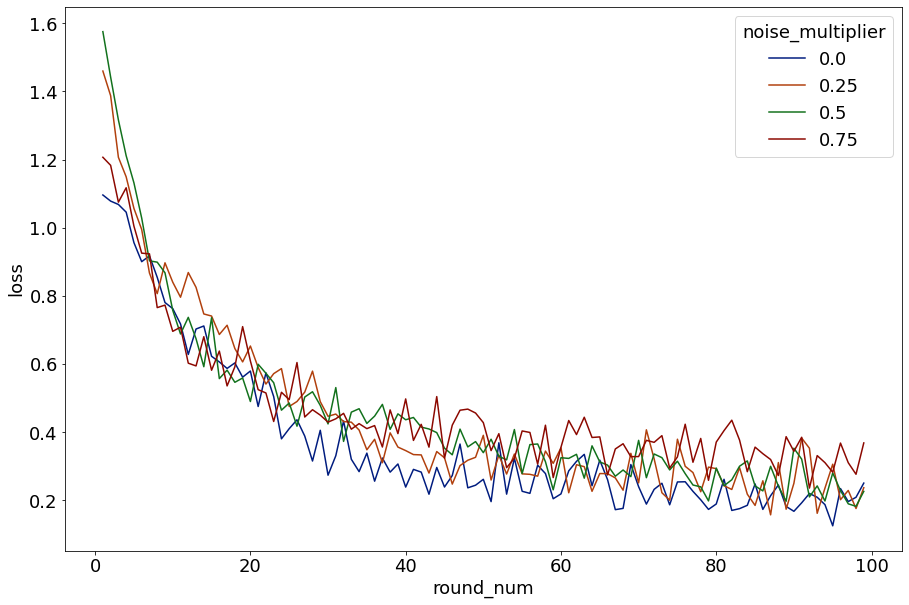

In [25]:
sns_fig = sns.lineplot(data=train_df, x='round_num', y='loss', hue='noise_multiplier', palette='dark')
sns_fig.figure.savefig('Train_plot_DP_loss.png')

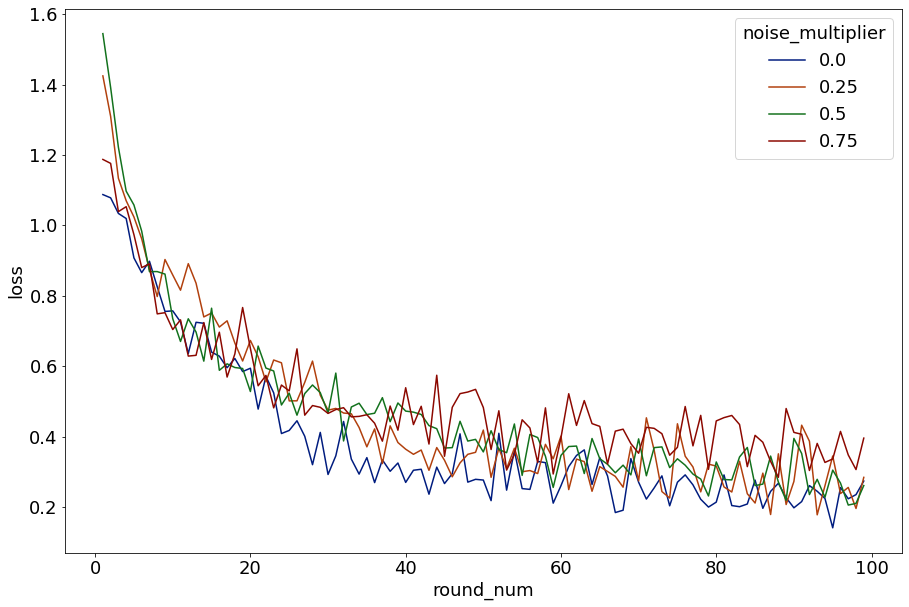

In [26]:
sns_fig = sns.lineplot(data=valid_df, x='round_num', y='loss', hue='noise_multiplier', palette='dark')
sns_fig.figure.savefig('Val_plot_DP_loss.png')

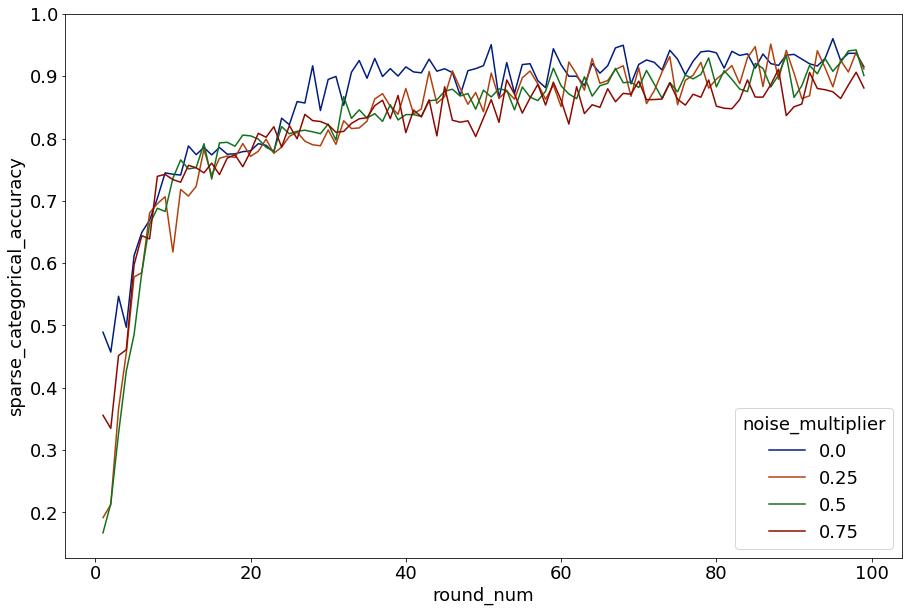

In [27]:
sns_fig = sns.lineplot(data=valid_df, x='round_num', y='sparse_categorical_accuracy', hue='noise_multiplier', palette='dark')
sns_fig.figure.savefig('val_plot_DP_accuracy.png')

In [127]:
8/15

0.5333333333333333

In [128]:
sampling_probability = 0.533

In [129]:
orders = [1 + x / 10. for x in range(1, 100)] + list(range(12, 64))

noise_multiplier = base_noise_multiplier
noise_multiplier *= clients_per_round / base_clients_per_round

rdp = tfp.compute_rdp(q=sampling_probability,
                  noise_multiplier=0.75,
                  steps=20,
                  orders=orders)


In [130]:
epsilon = tfp.get_privacy_spent(orders, rdp, target_delta=5e-5)

In [131]:
epsilon

(25.381315709982275, 5e-05, 1.8)

In [ ]:
# 3 clients in each training round 

In [ ]:
keras_model = create_keras_model()
model_weights = federated_training.get_model_weights(state)
model_weights.assign_weights_to(keras_model)

In [82]:
# rdp_orders = ([1.25, 1.5, 1.75, 2., 2.25, 2.5, 3., 3.5, 4., 4.5] +
#               list(range(5, 64)) + [128, 256, 512])

rdp_orders = [1 + x / 10. for x in range(1, 100)] + list(range(12, 64))

total_clients = 15
base_noise_multiplier = 0.15
base_clients_per_round = 1
target_delta = 5e-5
target_eps = 5

def get_epsilon(clients_per_round):
  # If we use this number of clients per round and proportionally
  # scale up the noise multiplier, what epsilon do we achieve?
  q = clients_per_round / total_clients
  noise_multiplier = base_noise_multiplier
  noise_multiplier *= clients_per_round / base_clients_per_round
  rdp = tfp.compute_rdp(
      q, noise_multiplier=noise_multiplier, steps=100, orders=rdp_orders)
  eps, _, _ = tfp.get_privacy_spent(rdp_orders, rdp, target_delta=target_delta)
  return clients_per_round, eps, noise_multiplier

def find_needed_clients_per_round():
    
    hi = get_epsilon(base_clients_per_round)
    print(hi)
    if hi[1] < target_eps:
        return hi
    
    # Grow interval exponentially until target_eps is exceeded.
    while True:
        lo = hi
        hi = get_epsilon(2 * lo[0])
        print(hi)
        if hi[1] < target_eps:
            break

    # Binary search.
    while hi[0] - lo[0] > 1:
        mid = get_epsilon((lo[0] + hi[0]) // 2)
        if mid[1] > target_eps:
            lo = mid
        else:
            hi = mid
    return hi

  

clients_per_round, _, noise_multiplier = find_needed_clients_per_round()
print(f'To get ({target_eps}, {target_delta})-DP, use {clients_per_round} '
      f'clients with noise multiplier {noise_multiplier}.')

(1, 509.7717588199019, 0.15)
(2, 136.10039787798246, 0.3)
(4, 52.51415511856102, 0.6)
(8, 32.6220090870771, 1.2)


ValueError: math domain error